In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import requests
import json
import dateutil
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import scipy
import statsmodels as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statistics
import math
from collections import Counter, OrderedDict

In [2]:
pd.set_option('display.max_columns', 30)

In [3]:
sns.set_style('darkgrid')

In [4]:
plt.rcParams["figure.figsize"] = [10, 10]

In [5]:
# report_date = (datetime.datetime.now().date() - datetime.timedelta(days=1)).strftime('%Y-%m-%d')
report_date = '2020-07-23'

In [6]:
age_df = pd.read_csv('../data/India/AgeGroupDetails.csv')

In [7]:
age_df.head(10)

,Sno,AgeGroup,TotalCases,Percentage
0,1,0-9,22,3.18%
1,2,10-19,27,3.90%
2,3,20-29,172,24.86%
3,4,30-39,146,21.10%
4,5,40-49,112,16.18%
5,6,50-59,77,11.13%
6,7,60-69,89,12.86%
7,8,70-79,28,4.05%
8,9,>=80,10,1.45%
9,10,Missing,9,1.30%


In [8]:
datetime_parser = lambda dt: datetime.strptime(x, '%Y-%m-%d %H:%M')

In [9]:
covid_df = pd.read_csv('../data/India/covid_19_india.csv', index_col='Sno')

In [10]:
hosp_df = pd.read_csv('../data/India/HospitalBedsIndia.csv')
hosp_df.head()

,Sno,State/UT,NumPrimaryHealthCenters_HMIS,NumCommunityHealthCenters_HMIS,NumSubDistrictHospitals_HMIS,NumDistrictHospitals_HMIS,TotalPublicHealthFacilities_HMIS,NumPublicBeds_HMIS,NumRuralHospitals_NHP18,NumRuralBeds_NHP18,NumUrbanHospitals_NHP18,NumUrbanBeds_NHP18
0,1,Andaman & Nicobar Islands,27,4,NaN,3,34,1246,27,575,3,500
1,2,Andhra Pradesh,1417,198,31.0,20,1666,60799,193,6480,65,16658
2,3,Arunachal Pradesh,122,62,NaN,15,199,2320,208,2136,10,268
3,4,Assam,1007,166,14.0,33,1220,19115,1176,10944,50,6198
4,5,Bihar,2007,63,33.0,43,2146,17796,930,6083,103,5936


In [11]:
icmr_df = pd.read_csv('../data/India/ICMRTestingLabs.csv')
icmr_df.head()

,lab,address,pincode,city,state,type
0,"ICMR-Regional Medical Research Centre, Port Blair","ICMR-Regional Medical Research Centre, Post Ba...",744103,Port Blair,Andaman and Nicobar Islands,Government Laboratory
1,Tomo Riba Institute of Health & Medical Scienc...,"National Highway 52A, Old Assembly Complex, Na...",791110,Naharlagun,Arunachal Pradesh,Collection Site
2,Sri Venkateswara Institute of Medical Sciences...,Sri Venkateswara Institute of Medical Sciences...,517507,Tirupati,Andhra Pradesh,Government Laboratory
3,"Rangaraya Medical College, Kakinada","Rangaraya Medical College, Kakinada Pithampura...",533001,Kakinada,Andhra Pradesh,Government Laboratory
4,"Sidhartha Medical College, Vijaywada","Siddhartha Medical College, Vijayawada NH 16 S...",520008,Vijayawada,Andhra Pradesh,Government Laboratory


In [12]:
patients_df = pd.read_csv('../data/India/IndividualDetails.csv')
patients_df.head()

,id,government_id,diagnosed_date,age,gender,detected_city,detected_district,detected_state,nationality,current_status,status_change_date,notes
0,0,KL-TS-P1,30/01/2020,20,F,Thrissur,Thrissur,Kerala,India,Recovered,14/02/2020,Travelled from Wuhan
1,1,KL-AL-P1,02/02/2020,NaN,NaN,Alappuzha,Alappuzha,Kerala,India,Recovered,14/02/2020,Travelled from Wuhan
2,2,KL-KS-P1,03/02/2020,NaN,NaN,Kasaragod,Kasaragod,Kerala,India,Recovered,14/02/2020,Travelled from Wuhan
3,3,DL-P1,02/03/2020,45,M,East Delhi (Mayur Vihar),East Delhi,Delhi,India,Recovered,15/03/2020,"Travelled from Austria, Italy"
4,4,TS-P1,02/03/2020,24,M,Hyderabad,Hyderabad,Telangana,India,Recovered,02/03/2020,"Travelled from Dubai to Bangalore on 20th Feb,..."


In [13]:
patients_data = "https://api.covid19india.org/raw_data%d.json"
list_json_data = []

for i in range(1, 8):
    json_response = requests.get(patients_data % i).text
    list_of_patients = json.loads(json_response)['raw_data']
    list_json_data.extend(list_of_patients)

In [14]:
list_json_data[-1]

{'agebracket': '',
 'contractedfromwhichpatientsuspected': '',
 'currentstatus': 'Hospitalized',
 'dateannounced': '30/06/2020',
 'detectedcity': '',
 'detecteddistrict': 'North Goa',
 'detectedstate': 'Goa',
 'entryid': '94848',
 'gender': '',
 'nationality': '',
 'notes': '',
 'numcases': '18',
 'patientnumber': '',
 'source1': '',
 'source2': '',
 'source3': '',
 'statecode': 'GA',
 'statepatientnumber': '',
 'statuschangedate': '',
 'typeoftransmission': ''}

In [15]:
new_patients_df = pd.DataFrame(list_json_data)
new_patients_df.head(5)

,agebracket,backupnotes,contractedfromwhichpatientsuspected,currentstatus,dateannounced,detectedcity,detecteddistrict,detectedstate,entryid,estimatedonsetdate,gender,nationality,notes,numcases,patientnumber,source1,source2,source3,statecode,statepatientnumber,statuschangedate,typeoftransmission
0,20,Student from Wuhan,,Recovered,30/01/2020,Thrissur,Thrissur,Kerala,NaN,,F,India,Travelled from Wuhan,1,1,https://twitter.com/vijayanpinarayi/status/122...,https://weather.com/en-IN/india/news/news/2020...,,KL,KL-TS-P1,14/02/2020,Imported
1,,Student from Wuhan,,Recovered,02/02/2020,Alappuzha,Alappuzha,Kerala,NaN,,,India,Travelled from Wuhan,1,2,https://www.indiatoday.in/india/story/kerala-r...,https://weather.com/en-IN/india/news/news/2020...,,KL,KL-AL-P1,14/02/2020,Imported
2,,Student from Wuhan,,Recovered,03/02/2020,Kasaragod,Kasaragod,Kerala,NaN,,,India,Travelled from Wuhan,1,3,https://www.indiatoday.in/india/story/kerala-n...,https://twitter.com/ANI/status/122422148580539...,https://weather.com/en-IN/india/news/news/2020...,KL,KL-KS-P1,14/02/2020,Imported
3,45,Travel history to Italy and Austria,,Recovered,02/03/2020,East Delhi (Mayur Vihar),East Delhi,Delhi,NaN,,M,India,"Travelled from Austria, Italy",1,4,https://www.indiatoday.in/india/story/not-a-ja...,https://economictimes.indiatimes.com/news/poli...,,DL,DL-P1,15/03/2020,Imported
4,24,"Travel history to Dubai, Singapore contact",,Recovered,02/03/2020,Hyderabad,Hyderabad,Telangana,NaN,,M,India,"Travelled from Dubai to Bangalore on 20th Feb,...",1,5,https://www.deccanherald.com/national/south/qu...,https://www.indiatoday.in/india/story/coronavi...,https://www.thehindu.com/news/national/coronav...,TG,TS-P1,02/03/2020,Imported


In [16]:
new_patients_df.to_csv('../data/India/new_patients_data.csv')

In [17]:
state_testing_df = pd.read_csv('../data/India/StatewiseTestingDetails.csv')
state_testing_df.head()

,Date,State,TotalSamples,Negative,Positive
0,2020-04-17,Andaman and Nicobar Islands,1403.0,1210,12.0
1,2020-04-24,Andaman and Nicobar Islands,2679.0,NaN,27.0
2,2020-04-27,Andaman and Nicobar Islands,2848.0,NaN,33.0
3,2020-05-01,Andaman and Nicobar Islands,3754.0,NaN,33.0
4,2020-05-16,Andaman and Nicobar Islands,6677.0,NaN,33.0


In [18]:
census_df = pd.read_csv('../data/India/population_india_census2011.csv')
census_df.head()

,Sno,State / Union Territory,Population,Rural population,Urban population,Area,Density,Gender Ratio
0,1,Uttar Pradesh,199812341,155317278,44495063,"240,928 km2 (93,023 sq mi)","828/km2 (2,140/sq mi)",912
1,2,Maharashtra,112374333,61556074,50818259,"307,713 km2 (118,809 sq mi)",365/km2 (950/sq mi),929
2,3,Bihar,104099452,92341436,11758016,"94,163 km2 (36,357 sq mi)","1,102/km2 (2,850/sq mi)",918
3,4,West Bengal,91276115,62183113,29093002,"88,752 km2 (34,267 sq mi)","1,029/km2 (2,670/sq mi)",953
4,5,Madhya Pradesh,72626809,52557404,20069405,"308,245 km2 (119,014 sq mi)",236/km2 (610/sq mi),931


### Data Cleaning

#### I. Covid 19 Data Frame

In [19]:
covid_df = pd.read_csv('../data/India/covid_19_india.csv', index_col='Sno')

In [20]:
covid_df.dtypes

Date                        object
Time                        object
State/UnionTerritory        object
ConfirmedIndianNational     object
ConfirmedForeignNational    object
Cured                        int64
Deaths                       int64
Confirmed                    int64
dtype: object

In [21]:
covid_df

,Date,Time,State/UnionTerritory,ConfirmedIndianNational,ConfirmedForeignNational,Cured,Deaths,Confirmed
Sno,,,,,,,,
1,30/01/20,6:00 PM,Kerala,1,0,0,0,1
2,31/01/20,6:00 PM,Kerala,1,0,0,0,1
3,01/02/20,6:00 PM,Kerala,2,0,0,0,2
4,02/02/20,6:00 PM,Kerala,3,0,0,0,3
5,03/02/20,6:00 PM,Kerala,3,0,0,0,3
6,04/02/20,6:00 PM,Kerala,3,0,0,0,3
7,05/02/20,6:00 PM,Kerala,3,0,0,0,3
8,06/02/20,6:00 PM,Kerala,3,0,0,0,3
9,07/02/20,6:00 PM,Kerala,3,0,0,0,3


In [22]:
covid_df.Date = pd.to_datetime(covid_df.Date, format='%d/%m/%y')
covid_df = covid_df.rename(columns={"State/UnionTerritory": "State"})
covid_df.loc[:, 'Active'] = covid_df.loc[:, 'Confirmed'] - covid_df.loc[:, 'Deaths'] - covid_df.loc[:, 'Cured']
covid_df = covid_df[['Date', 'State', 'Cured', 'Deaths', 'Confirmed', 'Active']]
covid_df.loc[:, "Fatality Rate"] = covid_df['Deaths'] / covid_df['Cured'] * 100

In [23]:
covid_df = covid_df[~(covid_df.State == 'Cases being reassigned to states')]
latest_df = covid_df[covid_df.Date == report_date]

In [24]:
latest_df

,Date,State,Cured,Deaths,Confirmed,Active,Fatality Rate
Sno,,,,,,,
4392,2020-07-23,Andaman and Nicobar Islands,163,0,221,58,0.000000
4393,2020-07-23,Andhra Pradesh,32127,823,64713,31763,2.561708
4394,2020-07-23,Arunachal Pradesh,314,3,949,632,0.955414
4395,2020-07-23,Assam,18033,64,26772,8675,0.354905
4396,2020-07-23,Bihar,19646,217,30369,10506,1.104551
4397,2020-07-23,Chandigarh,526,13,793,254,2.471483
4398,2020-07-23,Chhattisgarh,4230,29,5968,1709,0.685579
4399,2020-07-23,Dadra and Nagar Haveli and Daman and Diu,474,2,733,257,0.421941
4400,2020-07-23,Delhi,107650,3719,126323,14954,3.454714


#### Patients Df

In [25]:
new_patients_df = pd.DataFrame(list_json_data)

In [26]:
new_patients_df.head()

,agebracket,backupnotes,contractedfromwhichpatientsuspected,currentstatus,dateannounced,detectedcity,detecteddistrict,detectedstate,entryid,estimatedonsetdate,gender,nationality,notes,numcases,patientnumber,source1,source2,source3,statecode,statepatientnumber,statuschangedate,typeoftransmission
0,20,Student from Wuhan,,Recovered,30/01/2020,Thrissur,Thrissur,Kerala,NaN,,F,India,Travelled from Wuhan,1,1,https://twitter.com/vijayanpinarayi/status/122...,https://weather.com/en-IN/india/news/news/2020...,,KL,KL-TS-P1,14/02/2020,Imported
1,,Student from Wuhan,,Recovered,02/02/2020,Alappuzha,Alappuzha,Kerala,NaN,,,India,Travelled from Wuhan,1,2,https://www.indiatoday.in/india/story/kerala-r...,https://weather.com/en-IN/india/news/news/2020...,,KL,KL-AL-P1,14/02/2020,Imported
2,,Student from Wuhan,,Recovered,03/02/2020,Kasaragod,Kasaragod,Kerala,NaN,,,India,Travelled from Wuhan,1,3,https://www.indiatoday.in/india/story/kerala-n...,https://twitter.com/ANI/status/122422148580539...,https://weather.com/en-IN/india/news/news/2020...,KL,KL-KS-P1,14/02/2020,Imported
3,45,Travel history to Italy and Austria,,Recovered,02/03/2020,East Delhi (Mayur Vihar),East Delhi,Delhi,NaN,,M,India,"Travelled from Austria, Italy",1,4,https://www.indiatoday.in/india/story/not-a-ja...,https://economictimes.indiatimes.com/news/poli...,,DL,DL-P1,15/03/2020,Imported
4,24,"Travel history to Dubai, Singapore contact",,Recovered,02/03/2020,Hyderabad,Hyderabad,Telangana,NaN,,M,India,"Travelled from Dubai to Bangalore on 20th Feb,...",1,5,https://www.deccanherald.com/national/south/qu...,https://www.indiatoday.in/india/story/coronavi...,https://www.thehindu.com/news/national/coronav...,TG,TS-P1,02/03/2020,Imported


In [27]:
new_patients_df.dtypes

agebracket                             object
backupnotes                            object
contractedfromwhichpatientsuspected    object
currentstatus                          object
dateannounced                          object
detectedcity                           object
detecteddistrict                       object
detectedstate                          object
entryid                                object
estimatedonsetdate                     object
gender                                 object
nationality                            object
notes                                  object
numcases                               object
patientnumber                          object
source1                                object
source2                                object
source3                                object
statecode                              object
statepatientnumber                     object
statuschangedate                       object
typeoftransmission                

In [28]:
new_patients_df[new_patients_df['numcases'] == ''] = 0

In [29]:
new_patients_df[new_patients_df['patientnumber'] == ''] = 0

In [30]:
new_patients_df[['numcases', 'patientnumber']] = new_patients_df[['numcases', 'patientnumber']].astype(int)

In [31]:
new_patients_df.head()

,agebracket,backupnotes,contractedfromwhichpatientsuspected,currentstatus,dateannounced,detectedcity,detecteddistrict,detectedstate,entryid,estimatedonsetdate,gender,nationality,notes,numcases,patientnumber,source1,source2,source3,statecode,statepatientnumber,statuschangedate,typeoftransmission
0,20,Student from Wuhan,,Recovered,30/01/2020,Thrissur,Thrissur,Kerala,NaN,,F,India,Travelled from Wuhan,1,1,https://twitter.com/vijayanpinarayi/status/122...,https://weather.com/en-IN/india/news/news/2020...,,KL,KL-TS-P1,14/02/2020,Imported
1,,Student from Wuhan,,Recovered,02/02/2020,Alappuzha,Alappuzha,Kerala,NaN,,,India,Travelled from Wuhan,1,2,https://www.indiatoday.in/india/story/kerala-r...,https://weather.com/en-IN/india/news/news/2020...,,KL,KL-AL-P1,14/02/2020,Imported
2,,Student from Wuhan,,Recovered,03/02/2020,Kasaragod,Kasaragod,Kerala,NaN,,,India,Travelled from Wuhan,1,3,https://www.indiatoday.in/india/story/kerala-n...,https://twitter.com/ANI/status/122422148580539...,https://weather.com/en-IN/india/news/news/2020...,KL,KL-KS-P1,14/02/2020,Imported
3,45,Travel history to Italy and Austria,,Recovered,02/03/2020,East Delhi (Mayur Vihar),East Delhi,Delhi,NaN,,M,India,"Travelled from Austria, Italy",1,4,https://www.indiatoday.in/india/story/not-a-ja...,https://economictimes.indiatimes.com/news/poli...,,DL,DL-P1,15/03/2020,Imported
4,24,"Travel history to Dubai, Singapore contact",,Recovered,02/03/2020,Hyderabad,Hyderabad,Telangana,NaN,,M,India,"Travelled from Dubai to Bangalore on 20th Feb,...",1,5,https://www.deccanherald.com/national/south/qu...,https://www.indiatoday.in/india/story/coronavi...,https://www.thehindu.com/news/national/coronav...,TG,TS-P1,02/03/2020,Imported


In [32]:
new_patients_df_min = new_patients_df[['currentstatus', 'detectedcity', 
                                       'detecteddistrict', 'detectedstate',
                                      'gender', 'nationality', 'numcases', 'patientnumber', 'statepatientnumber'
                                       ,'typeoftransmission']]

In [33]:
new_patients_df_min.currentstatus.unique()

array(['Recovered', 'Hospitalized', 'Deceased', 'Migrated', 0,
       'Migrated_Other', ''], dtype=object)

In [34]:
new_patients_df_min.head()

,currentstatus,detectedcity,detecteddistrict,detectedstate,gender,nationality,numcases,patientnumber,statepatientnumber,typeoftransmission
0,Recovered,Thrissur,Thrissur,Kerala,F,India,1,1,KL-TS-P1,Imported
1,Recovered,Alappuzha,Alappuzha,Kerala,,India,1,2,KL-AL-P1,Imported
2,Recovered,Kasaragod,Kasaragod,Kerala,,India,1,3,KL-KS-P1,Imported
3,Recovered,East Delhi (Mayur Vihar),East Delhi,Delhi,M,India,1,4,DL-P1,Imported
4,Recovered,Hyderabad,Hyderabad,Telangana,M,India,1,5,TS-P1,Imported


In [35]:
new_patients_df_min[new_patients_df_min.currentstatus == 'Deceased'].head()

,currentstatus,detectedcity,detecteddistrict,detectedstate,gender,nationality,numcases,patientnumber,statepatientnumber,typeoftransmission
72,Deceased,Janakpuri,South West Delhi,Delhi,F,India,1,72,DL-P6,Local
76,Deceased,Mumbai,Mumbai,Maharashtra,M,India,1,77,,Imported
81,Deceased,Kalaburagi,Kalaburagi,Karnataka,M,India,1,74,KA-P6,Imported
181,Deceased,Banga,Shahid Bhagat Singh Nagar,Punjab,M,India,1,182,PJ-P2,Imported
269,Deceased,Mumbai,Mumbai,Maharashtra,M,India,1,270,,Imported


In [36]:
new_patients_df_min_deceased = new_patients_df_min[(new_patients_df_min.currentstatus == 'Deceased') & (new_patients_df_min.numcases > 0)]

In [37]:
new_patients_df_min_deceased = new_patients_df_min_deceased[~(new_patients_df_min_deceased.detecteddistrict == '')] 

### Statewise Testing

In [38]:
state_testing_df.dtypes

Date             object
State            object
TotalSamples    float64
Negative         object
Positive        float64
dtype: object

In [39]:
state_testing_df.Date = pd.to_datetime(state_testing_df.Date, format='%Y-%m-%d')

In [40]:
state_testing_df = state_testing_df.set_index('Date')

In [41]:
state_testing_df.describe()

,TotalSamples,Positive
count,3.400000e+03,3386.000000
mean,1.766570e+05,10122.555818
std,2.876818e+05,29780.768372
min,5.800000e+01,0.000000
25%,1.042700e+04,130.000000
50%,4.826750e+04,1077.000000
75%,2.228228e+05,6640.750000
max,2.157869e+06,352760.000000


In [42]:
state_testing_df.isna().sum()

State              0
TotalSamples       0
Negative        1119
Positive          14
dtype: int64

In [43]:
state_testing_df[state_testing_df['Positive'].isna()]

,State,TotalSamples,Negative,Positive
Date,,,,
2020-07-23,Assam,723287.0,NaN,NaN
2020-04-01,Delhi,2621.0,NaN,NaN
2020-07-23,Gujarat,591561.0,NaN,NaN
2020-04-05,Maharashtra,16008.0,14837,NaN
2020-05-04,Sikkim,170.0,169,NaN
2020-07-15,Sikkim,13352.0,11355,NaN
2020-07-17,Uttar Pradesh,1379534.0,NaN,NaN
2020-07-21,Uttar Pradesh,1554116.0,NaN,NaN
2020-04-04,West Bengal,1042.0,NaN,NaN


In [44]:
state_testing_df['Negative'] = state_testing_df['TotalSamples'] - state_testing_df['Positive']

In [45]:
state_testing_df.isna().sum()

State            0
TotalSamples     0
Negative        14
Positive        14
dtype: int64

In [46]:
state_testing_df = state_testing_df[~(state_testing_df.Positive.isna())]

In [47]:
covid_temp = covid_df

In [48]:
covid_temp = covid_temp.set_index('Date')

In [49]:
covid_temp.head()

,State,Cured,Deaths,Confirmed,Active,Fatality Rate
Date,,,,,,
2020-01-30,Kerala,0,0,1,1,NaN
2020-01-31,Kerala,0,0,1,1,NaN
2020-02-01,Kerala,0,0,2,2,NaN
2020-02-02,Kerala,0,0,3,3,NaN
2020-02-03,Kerala,0,0,3,3,NaN


In [50]:
merged_df = pd.merge(covid_temp, state_testing_df, how='inner', left_index=True, right_index=True, on='State')

In [51]:
state_testing_temp = state_testing_df
state_testing_temp = state_testing_temp.set_index(['State'], append=True)
covid_temp = covid_temp.set_index(['State'], append=True)

In [52]:
merged_df = pd.merge(covid_temp, state_testing_temp, left_index=True, right_index=True, how='left').fillna(0)

In [53]:
merged_df = merged_df.sort_index(level=0, ascending=False)

In [54]:
# covid_df.loc[:, "Positive Rate"] = covid_df['Deaths'] / covid_df['Cured'] * 100
merged_df.loc[merged_df.index.get_level_values(1) == 'Maharashtra']

,,Cured,Deaths,Confirmed,Active,Fatality Rate,TotalSamples,Negative,Positive
Date,State,,,,,,,,
2020-07-24,Maharashtra,194253,12854,347502,140395,6.617144,0.0,0.0,0.0
2020-07-23,Maharashtra,187769,12556,337607,137282,6.686940,1741992.0,1389232.0,352760.0
2020-07-22,Maharashtra,182217,12276,327031,132538,6.737022,1691546.0,1348610.0,342936.0
2020-07-21,Maharashtra,175029,12030,318695,131636,6.873147,1643981.0,1311150.0,332831.0
2020-07-20,Maharashtra,169569,11854,310455,129032,6.990665,1603802.0,1279592.0,324210.0
2020-07-19,Maharashtra,165663,11596,300937,123678,6.999753,1568229.0,1252842.0,315387.0
2020-07-18,Maharashtra,160357,11452,292589,120780,7.141565,1526037.0,1220496.0,305541.0
2020-07-17,Maharashtra,158140,11194,284281,114947,7.078538,1487738.0,1190958.0,296780.0
2020-07-16,Maharashtra,152613,10928,275640,112099,7.160596,1450129.0,1161433.0,288696.0


## Data Analysis

### Top 10 States with Max Fatalities

In [55]:
merged_df.head()

Cured  Deaths  Confirmed  Active  Fatality Rate  \
Date       State                                                            
2020-07-24 West Bengal    31656    1255      51757   18846       3.964493   
           Uttarakhand     3399      60       5445    1986       1.765225   
           Uttar Pradesh  35803    1289      58104   21012       3.600257   
           Tripura         2072      10       3656    1574       0.482625   
           Telangana      39327     447      50826   11052       1.136624   

                          TotalSamples  Negative  Positive  
Date       State                                            
2020-07-24 West Bengal             0.0       0.0       0.0  
           Uttarakhand             0.0       0.0       0.0  
           Uttar Pradesh           0.0       0.0       0.0  
           Tripura                 0.0       0.0       0.0  
           Telangana               0.0       0.0       0.0

In [56]:
latest_df = latest_df.sort_values(by='Deaths', ascending=False)
top_10_states_with_highest_fatalities = latest_df[:10]

In [57]:
top_10_states_with_highest_fatalities.head()

,Date,State,Cured,Deaths,Confirmed,Active,Fatality Rate
Sno,,,,,,,
4411,2020-07-23,Maharashtra,187769,12556,337607,137282,6.686940
4400,2020-07-23,Delhi,107650,3719,126323,14954,3.454714
4421,2020-07-23,Tamil Nadu,131583,3144,186492,51765,2.389366
4402,2020-07-23,Gujarat,37260,2224,51399,11915,5.968867
4407,2020-07-23,Karnataka,27239,1519,75833,47075,5.576563


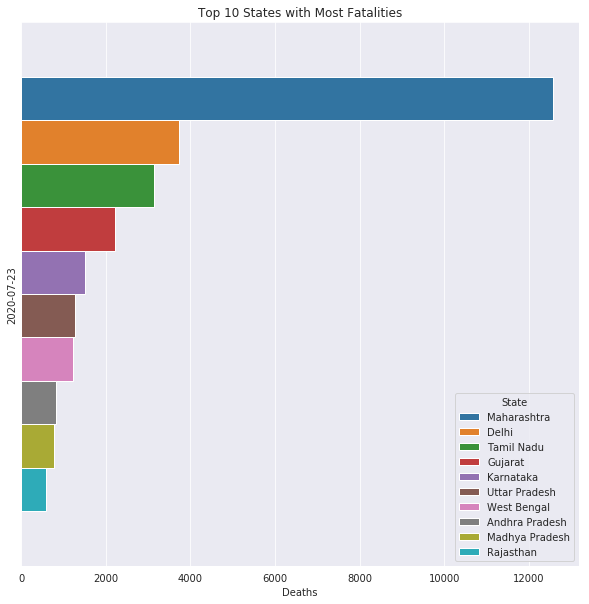

In [58]:
sns.barplot(y=top_10_states_with_highest_fatalities.Date, x=top_10_states_with_highest_fatalities.Deaths, hue=top_10_states_with_highest_fatalities.State, orient='h')
plt.title('Top 10 States with Most Fatalities')
plt.ylabel(report_date)
plt.yticks([])
plt.show()

### Top 10 States with Highest Fatality Rates

In [59]:
latest_df = latest_df.sort_values(by='Fatality Rate', ascending=False)

In [60]:
top_10_states_with_highest_fatality_rate = latest_df[:10]

In [61]:
top_10_states_with_highest_fatality_rate.head()

,Date,State,Cured,Deaths,Confirmed,Active,Fatality Rate
Sno,,,,,,,
4411,2020-07-23,Maharashtra,187769,12556,337607,137282,6.686940
4402,2020-07-23,Gujarat,37260,2224,51399,11915,5.968867
4407,2020-07-23,Karnataka,27239,1519,75833,47075,5.576563
4413,2020-07-23,Meghalaya,77,4,514,433,5.194805
4410,2020-07-23,Madhya Pradesh,16836,770,24842,7236,4.573533


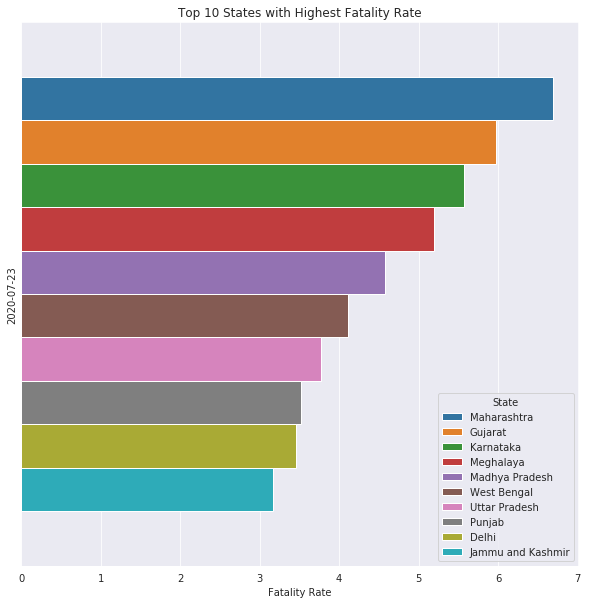

In [62]:
sns.barplot(y=top_10_states_with_highest_fatality_rate.Date, x=top_10_states_with_highest_fatality_rate['Fatality Rate'], hue=top_10_states_with_highest_fatality_rate.State, orient='h')
plt.title('Top 10 States with Highest Fatality Rate')
plt.ylabel(report_date)
plt.yticks([])
plt.show()

### Finding

- Maharashtra, having the highest number of fatalities due to Covid-19, also has the highest mortality rate, since rate.
- Gujarat, having the third highest number of casualties, has second highest fatality rate.

In [63]:
top_7_states = ["Maharashtra", 'Gujarat', 'Madhya Pradesh', 'Delhi', 'West Bengal', 'Uttar Pradesh', 'Bihar']

In [64]:
top_7_states_df = covid_df[covid_df.State.isin(top_7_states)]
top_7_states_df = top_7_states_df.set_index('Date')

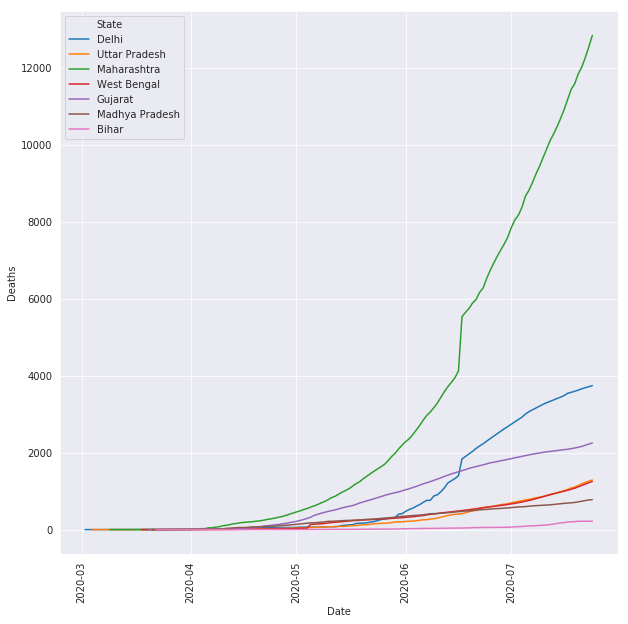

In [65]:
sns.lineplot(x=top_7_states_df.index, y=top_7_states_df.Deaths, hue=top_7_states_df.State)
plt.xticks(rotation=90)
plt.show()

#### Finding:

- Uttar Pradesh, having highest population amongst Indian states has low number of fatalities.
- Bihar, having third highest population in India, has least number of fatalities, amongst top populated states.

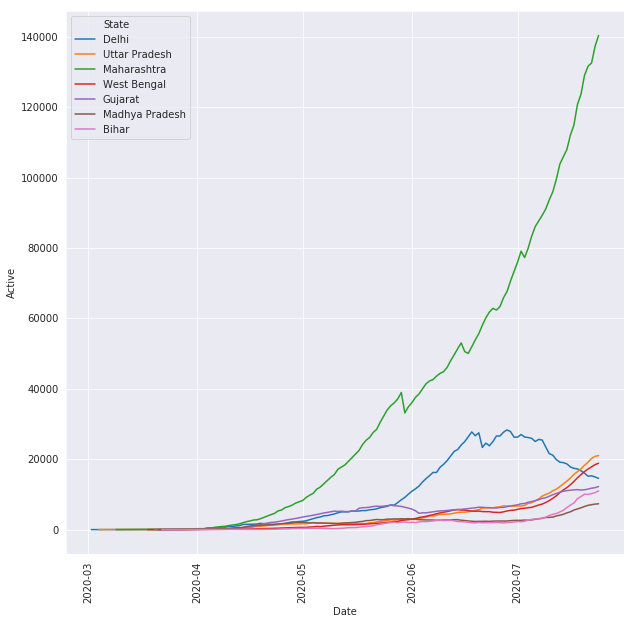

In [66]:
sns.lineplot(x=top_7_states_df.index, y=top_7_states_df.Active, hue=top_7_states_df.State)
plt.xticks(rotation=90)
plt.show()

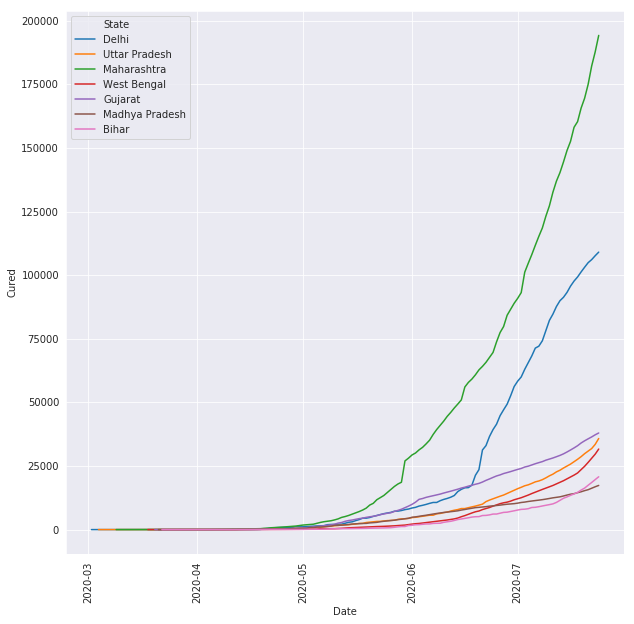

In [67]:
sns.lineplot(x=top_7_states_df.index, y=top_7_states_df.Cured, hue=top_7_states_df.State)
plt.xticks(rotation=90)
plt.show()

#### Finding:
- West Bengal is one of the states with least recovery rate.

### Top 5 districts with maximum fatalities in India

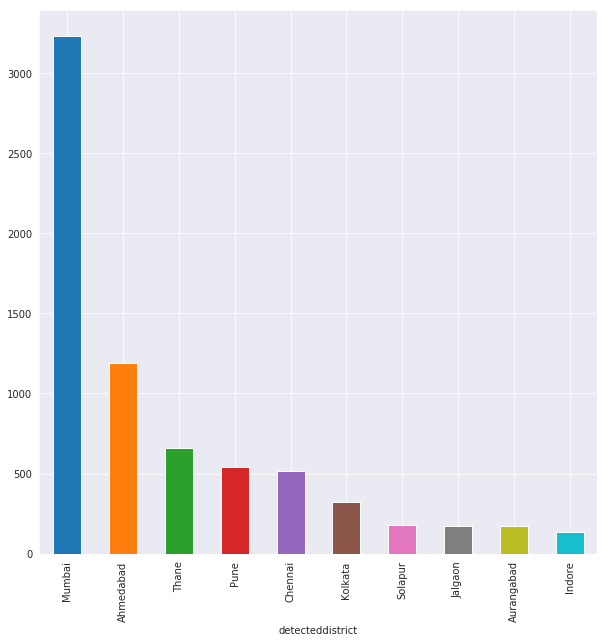

In [68]:
new_patients_df_min_deceased.groupby(['detecteddistrict'])['numcases'].sum().sort_values(ascending=False).head(10).plot(kind='bar')
plt.show()

### Day wise Covid-19 statistics for each State

In [69]:
merged_df.head(20)

Cured  Deaths  Confirmed  Active  Fatality Rate  \
Date       State                                                              
2020-07-24 West Bengal      31656    1255      51757   18846       3.964493   
           Uttarakhand       3399      60       5445    1986       1.765225   
           Uttar Pradesh    35803    1289      58104   21012       3.600257   
           Tripura           2072      10       3656    1574       0.482625   
           Telangana        39327     447      50826   11052       1.136624   
           Tamil Nadu      136793    3232     192964   52939       2.362694   
           Sikkim             122       0        460     338       0.000000   
           Rajasthan        23815     594      33220    8811       2.494226   
           Punjab            7741     277      11739    3721       3.578349   
           Puducherry        1400      34       2420     986       2.428571   
           Odisha           14393     114      21099    6592       0.792052   
           Nagaland           530       0       1174     644       0.000000   
           Mizoram            183       0        332     149       0.000000   
           Meghalaya           78       4        534     452       5.128205   
           Manipur           1466       0       2115     649       0.000000   
           Maharashtra     194253   12854     347502  140395       6.617144   
           Madhya Pradesh   17359     780      25474    7335       4.493346   
           Ladakh            1025       2       1210     183       0.195122   
           Kerala            6594      50      16110    9466       0.758265   
           Karnataka        29310    1616      80863   49937       5.513477   

                           TotalSamples  Negative  Positive  
Date       State                                             
2020-07-24 West Bengal              0.0       0.0       0.0  
           Uttarakhand              0.0       0.0       0.0  
           Uttar Pradesh            0.0       0.0       0.0  
           Tripura                  0.0       0.0       0.0  
           Telangana                0.0       0.0       0.0  
           Tamil Nadu               0.0       0.0       0.0  
           Sikkim                   0.0       0.0       0.0  
           Rajasthan                0.0       0.0       0.0  
           Punjab                   0.0       0.0       0.0  
           Puducherry               0.0       0.0       0.0  
           Odisha                   0.0       0.0       0.0  
           Nagaland                 0.0       0.0       0.0  
           Mizoram                  0.0       0.0       0.0  
           Meghalaya                0.0       0.0       0.0  
           Manipur                  0.0       0.0       0.0  
           Maharashtra              0.0       0.0       0.0  
           Madhya Pradesh           0.0       0.0       0.0  
           Ladakh                   0.0       0.0       0.0  
           Kerala                   0.0       0.0       0.0  
           Karnataka                0.0       0.0       0.0

### State Level Aggregated DF with Census DF and Covid Counts

In [70]:
census_df = census_df.rename(columns={"State / Union Territory": "State"}).set_index('State').drop(columns='Sno')

In [71]:
aggregated_df = pd.merge(merged_df, census_df, left_index=True, right_index=True)

In [72]:
aggregated_df.head()

Cured  Deaths  Confirmed  Active  Fatality Rate  \
Date       State                                                             
2020-07-24 West Bengal     31656    1255      51757   18846       3.964493   
           Uttarakhand      3399      60       5445    1986       1.765225   
           Uttar Pradesh   35803    1289      58104   21012       3.600257   
           Tripura          2072      10       3656    1574       0.482625   
           Tamil Nadu     136793    3232     192964   52939       2.362694   

                          TotalSamples  Negative  Positive  Population  \
Date       State                                                         
2020-07-24 West Bengal             0.0       0.0       0.0    91276115   
           Uttarakhand             0.0       0.0       0.0    10086292   
           Uttar Pradesh           0.0       0.0       0.0   199812341   
           Tripura                 0.0       0.0       0.0     3673917   
           Tamil Nadu              0.0       0.0       0.0    72147030   

                          Rural population  Urban population  \
Date       State                                               
2020-07-24 West Bengal            62183113          29093002   
           Uttarakhand             7036954           3049338   
           Uttar Pradesh         155317278          44495063   
           Tripura                 2712464            961453   
           Tamil Nadu             37229590          34917440   

                                                Area                  Density  \
Date       State                                                                
2020-07-24 West Bengal     88,752 km2 (34,267 sq mi)  1,029/km2 (2,670/sq mi)   
           Uttarakhand     53,483 km2 (20,650 sq mi)      189/km2 (490/sq mi)   
           Uttar Pradesh  240,928 km2 (93,023 sq mi)    828/km2 (2,140/sq mi)   
           Tripura          10,486 km2 (4,049 sq mi)      350/km2 (910/sq mi)   
           Tamil Nadu     130,058 km2 (50,216 sq mi)    555/km2 (1,440/sq mi)   

                          Gender Ratio  
Date       State                        
2020-07-24 West Bengal             953  
           Uttarakhand             963  
           Uttar Pradesh           912  
           Tripura                 960  
           Tamil Nadu              996

In [73]:
hosp_df_min = hosp_df[['State/UT', 'NumPublicBeds_HMIS', 'NumRuralBeds_NHP18', 'NumUrbanBeds_NHP18']]

In [74]:
hosp_df_min = hosp_df_min.rename(columns={"State/UT":"State", "NumPublicBeds_HMIS": "Public Beds", 
                            "NumRuralBeds_NHP18": "Rural Beds", "NumUrbanBeds_NHP18": "Urban Beds"}).set_index('State')

In [75]:
aggregated_df = pd.merge(aggregated_df, hosp_df_min, left_index=True, right_index=True)

In [76]:
aggregated_df.head()

Cured  Deaths  Confirmed  Active  Fatality Rate  \
Date       State                                                             
2020-07-24 West Bengal     31656    1255      51757   18846       3.964493   
           Uttarakhand      3399      60       5445    1986       1.765225   
           Uttar Pradesh   35803    1289      58104   21012       3.600257   
           Tripura          2072      10       3656    1574       0.482625   
           Tamil Nadu     136793    3232     192964   52939       2.362694   

                          TotalSamples  Negative  Positive  Population  \
Date       State                                                         
2020-07-24 West Bengal             0.0       0.0       0.0    91276115   
           Uttarakhand             0.0       0.0       0.0    10086292   
           Uttar Pradesh           0.0       0.0       0.0   199812341   
           Tripura                 0.0       0.0       0.0     3673917   
           Tamil Nadu              0.0       0.0       0.0    72147030   

                          Rural population  Urban population  \
Date       State                                               
2020-07-24 West Bengal            62183113          29093002   
           Uttarakhand             7036954           3049338   
           Uttar Pradesh         155317278          44495063   
           Tripura                 2712464            961453   
           Tamil Nadu             37229590          34917440   

                                                Area                  Density  \
Date       State                                                                
2020-07-24 West Bengal     88,752 km2 (34,267 sq mi)  1,029/km2 (2,670/sq mi)   
           Uttarakhand     53,483 km2 (20,650 sq mi)      189/km2 (490/sq mi)   
           Uttar Pradesh  240,928 km2 (93,023 sq mi)    828/km2 (2,140/sq mi)   
           Tripura          10,486 km2 (4,049 sq mi)      350/km2 (910/sq mi)   
           Tamil Nadu     130,058 km2 (50,216 sq mi)    555/km2 (1,440/sq mi)   

                          Gender Ratio  Public Beds  Rural Beds  Urban Beds  
Date       State                                                             
2020-07-24 West Bengal             953        51163       19684       58882  
           Uttarakhand             963         6660        3284        5228  
           Uttar Pradesh           912        58310       39104       37156  
           Tripura                 960         4895        1140        3277  
           Tamil Nadu              996        72616       40179       37353

In [77]:
fatality_df = covid_df[covid_df['Fatality Rate'].notna()]
fatality_df = fatality_df[~(fatality_df['Fatality Rate'] == np.inf)]
fatality_df.dtypes

Date             datetime64[ns]
State                    object
Cured                     int64
Deaths                    int64
Confirmed                 int64
Active                    int64
Fatality Rate           float64
dtype: object

In [78]:
fatality_df = fatality_df.set_index('Date')
fatality_rate_maha = fatality_df[fatality_df['State'] == 'Maharashtra']

In [79]:
states = ['Maharashtra', 'Delhi', 'Gujarat', 'Kerela', 'Madhya Pradesh', "Uttar Pradesh"]

In [80]:
df_temp = fatality_df[fatality_df.State.isin(states)]

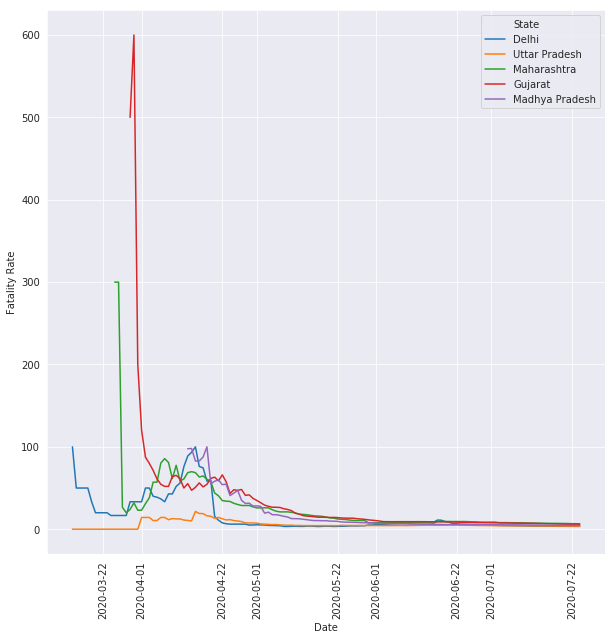

In [81]:
sns.lineplot(x=df_temp.index, y=df_temp['Fatality Rate'], hue=df_temp['State'])
plt.xticks(rotation=90)
plt.show()

In [82]:
aggregated_df.head()

Cured  Deaths  Confirmed  Active  Fatality Rate  \
Date       State                                                             
2020-07-24 West Bengal     31656    1255      51757   18846       3.964493   
           Uttarakhand      3399      60       5445    1986       1.765225   
           Uttar Pradesh   35803    1289      58104   21012       3.600257   
           Tripura          2072      10       3656    1574       0.482625   
           Tamil Nadu     136793    3232     192964   52939       2.362694   

                          TotalSamples  Negative  Positive  Population  \
Date       State                                                         
2020-07-24 West Bengal             0.0       0.0       0.0    91276115   
           Uttarakhand             0.0       0.0       0.0    10086292   
           Uttar Pradesh           0.0       0.0       0.0   199812341   
           Tripura                 0.0       0.0       0.0     3673917   
           Tamil Nadu              0.0       0.0       0.0    72147030   

                          Rural population  Urban population  \
Date       State                                               
2020-07-24 West Bengal            62183113          29093002   
           Uttarakhand             7036954           3049338   
           Uttar Pradesh         155317278          44495063   
           Tripura                 2712464            961453   
           Tamil Nadu             37229590          34917440   

                                                Area                  Density  \
Date       State                                                                
2020-07-24 West Bengal     88,752 km2 (34,267 sq mi)  1,029/km2 (2,670/sq mi)   
           Uttarakhand     53,483 km2 (20,650 sq mi)      189/km2 (490/sq mi)   
           Uttar Pradesh  240,928 km2 (93,023 sq mi)    828/km2 (2,140/sq mi)   
           Tripura          10,486 km2 (4,049 sq mi)      350/km2 (910/sq mi)   
           Tamil Nadu     130,058 km2 (50,216 sq mi)    555/km2 (1,440/sq mi)   

                          Gender Ratio  Public Beds  Rural Beds  Urban Beds  
Date       State                                                             
2020-07-24 West Bengal             953        51163       19684       58882  
           Uttarakhand             963         6660        3284        5228  
           Uttar Pradesh           912        58310       39104       37156  
           Tripura                 960         4895        1140        3277  
           Tamil Nadu              996        72616       40179       37353

In [83]:
aggregated_df.loc[:, 'Total Beds'] = aggregated_df['Public Beds'] + aggregated_df['Rural Beds'] + aggregated_df['Urban Beds']

/home/akash/Dev/python/venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2819: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)


In [84]:
latest_df = aggregated_df.loc[aggregated_df.index.get_level_values(0) == report_date]
latest_df = latest_df.reset_index()
latest_df = latest_df.set_index('State')
latest_df = latest_df[latest_df.Confirmed > 1000]

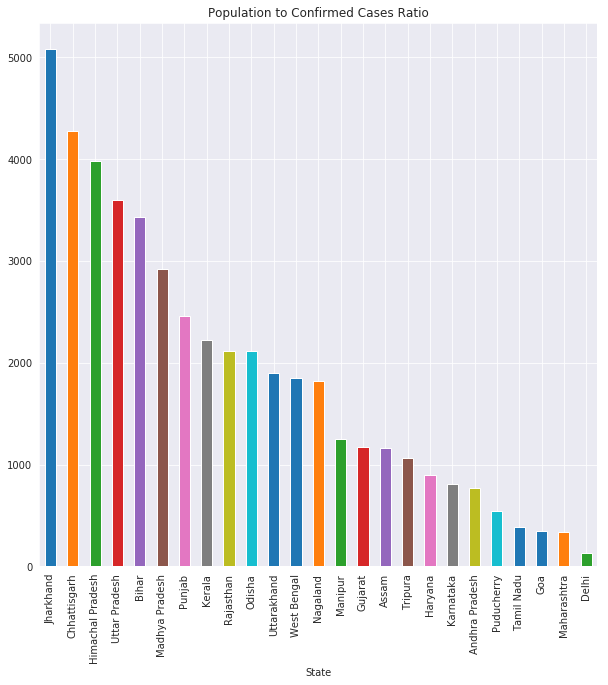

In [85]:
ser_pop_confirmed_ratio = (latest_df.Population / latest_df.Confirmed).sort_values(ascending=False)
ser_pop_confirmed_ratio.plot(kind='bar')
plt.title('Population to Confirmed Cases Ratio')
plt.show()

In [86]:
ser_pop_confirmed_ratio

State
Jharkhand           5086.836392
Chhattisgarh        4280.361595
Himachal Pradesh    3979.479420
Uttar Pradesh       3594.522937
Bihar               3427.819553
Madhya Pradesh      2923.549191
Punjab              2454.945403
Kerala              2222.329763
Rajasthan           2120.011041
Odisha              2116.169297
Uttarakhand         1903.073962
West Bengal         1850.654184
Nagaland            1825.186347
Manipur             1247.762136
Gujarat             1175.892371
Assam               1165.604960
Tripura             1065.212235
Haryana              899.434542
Karnataka            805.655809
Andhra Pradesh       766.107320
Puducherry           542.588261
Tamil Nadu           386.863941
Goa                  349.268439
Maharashtra          332.855459
Delhi                132.896947
dtype: float64

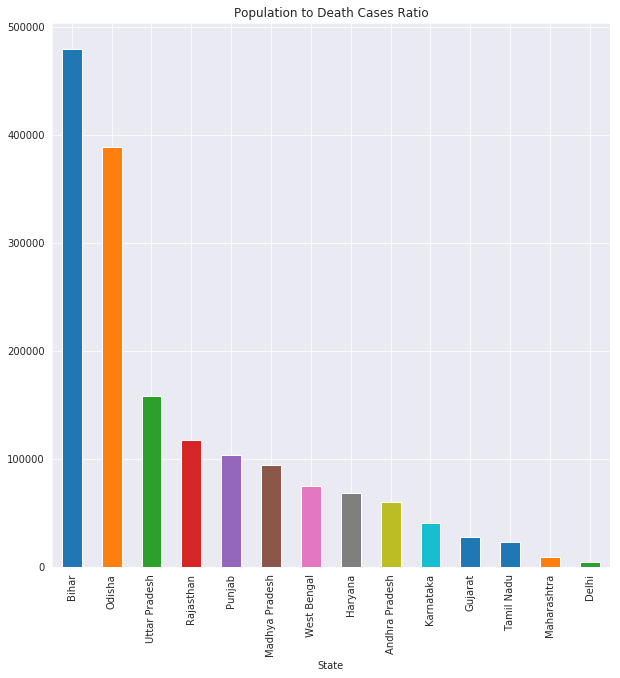

In [87]:
latest_df = aggregated_df.loc[aggregated_df.index.get_level_values(0) == report_date]
latest_df = latest_df.reset_index()
latest_df = latest_df.set_index('State')
latest_df = latest_df[latest_df.Deaths > 100]

ser_pop_deaths_ratio = (latest_df.Population / latest_df.Deaths).sort_values(ascending=False)
ser_pop_deaths_ratio.plot(kind='bar')
plt.title('Population to Death Cases Ratio')
plt.show()

In [88]:
ser_pop_deaths_ratio

State
Bihar             479720.976959
Odisha            388650.166667
Uttar Pradesh     158204.545527
Rajasthan         117578.794168
Punjab            103135.085502
Madhya Pradesh     94320.531169
West Bengal        74755.212940
Haryana            68149.091398
Andhra Pradesh     60239.493317
Karnataka          40220.735352
Gujarat            27176.120504
Tamil Nadu         22947.528626
Maharashtra         8949.851306
Delhi               4514.100834
dtype: float64

### Beds to Active Patients Ratio

In [89]:
latest_df = aggregated_df.loc[aggregated_df.index.get_level_values(0) == report_date, :].reset_index()
latest_df.loc[:, 'Beds/Active'] = latest_df['Total Beds'] / latest_df['Active']
df_least_beds_to_patients_ratio = latest_df.sort_values(by='Beds/Active', ascending=True).head(10)

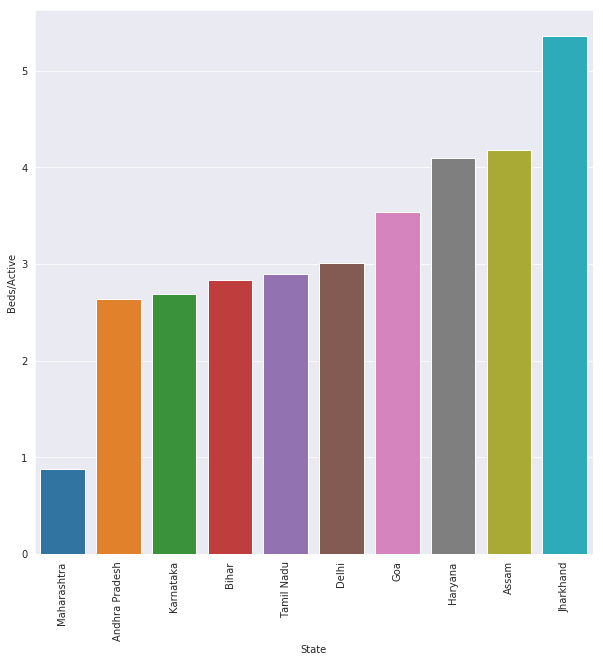

In [90]:
sns.barplot(x=df_least_beds_to_patients_ratio.State, y=df_least_beds_to_patients_ratio['Beds/Active'])
plt.xticks(rotation=90)
plt.show()

### Finding:

- As per above statistics, if we include only covid patients, there are only 2.5 beds available for 1 covid-19 patient in Maharashtra, which is alarming, given covid-19 is yet to peak.


- Also, there are only 2 beds available for each covid-19 patient in Delhi.

### Mortality rate per 1000000

In [91]:
latest_df.loc[:, 'Mortality/1000000'] = (latest_df['Deaths'] / latest_df['Population']) * 1000000
latest_df['Population_Density_square_km'] = latest_df['Density'].str.split('/').str[0]
latest_df.head()

,Date,State,Cured,Deaths,Confirmed,Active,Fatality Rate,TotalSamples,Negative,Positive,Population,Rural population,Urban population,Area,Density,Gender Ratio,Public Beds,Rural Beds,Urban Beds,Total Beds,Beds/Active,Mortality/1000000,Population_Density_square_km
0,2020-07-23,West Bengal,29650,1221,49321,18450,4.118044,758027.0,706270.0,51757.0,91276115,62183113,29093002,"88,752 km2 (34,267 sq mi)","1,029/km2 (2,670/sq mi)",953,51163,19684,58882,129729,7.031382,13.376994,"1,029"
1,2020-07-23,Uttarakhand,3349,57,5300,1894,1.702001,132840.0,127395.0,5445.0,10086292,7036954,3049338,"53,483 km2 (20,650 sq mi)",189/km2 (490/sq mi),963,6660,3284,5228,15172,8.010560,5.651234,189
2,2020-07-23,Uttar Pradesh,33500,1263,55588,20825,3.770149,1654651.0,1596547.0,58104.0,199812341,155317278,44495063,"240,928 km2 (93,023 sq mi)","828/km2 (2,140/sq mi)",912,58310,39104,37156,134570,6.461945,6.320931,828
3,2020-07-23,Tripura,2032,9,3449,1408,0.442913,127742.0,124065.0,3677.0,3673917,2712464,961453,"10,486 km2 (4,049 sq mi)",350/km2 (910/sq mi),960,4895,1140,3277,9312,6.613636,2.449702,350
4,2020-07-23,Tamil Nadu,131583,3144,186492,51765,2.389366,2157869.0,1964905.0,192964.0,72147030,37229590,34917440,"130,058 km2 (50,216 sq mi)","555/km2 (1,440/sq mi)",996,72616,40179,37353,150148,2.900570,43.577677,555


In [92]:
latest_df['Population_Density_square_km'] = latest_df['Population_Density_square_km'].str.replace(',', '')
latest_df['Population_Density_square_km'] = latest_df['Population_Density_square_km'].astype(np.int)

In [93]:
latest_df.head()

,Date,State,Cured,Deaths,Confirmed,Active,Fatality Rate,TotalSamples,Negative,Positive,Population,Rural population,Urban population,Area,Density,Gender Ratio,Public Beds,Rural Beds,Urban Beds,Total Beds,Beds/Active,Mortality/1000000,Population_Density_square_km
0,2020-07-23,West Bengal,29650,1221,49321,18450,4.118044,758027.0,706270.0,51757.0,91276115,62183113,29093002,"88,752 km2 (34,267 sq mi)","1,029/km2 (2,670/sq mi)",953,51163,19684,58882,129729,7.031382,13.376994,1029
1,2020-07-23,Uttarakhand,3349,57,5300,1894,1.702001,132840.0,127395.0,5445.0,10086292,7036954,3049338,"53,483 km2 (20,650 sq mi)",189/km2 (490/sq mi),963,6660,3284,5228,15172,8.010560,5.651234,189
2,2020-07-23,Uttar Pradesh,33500,1263,55588,20825,3.770149,1654651.0,1596547.0,58104.0,199812341,155317278,44495063,"240,928 km2 (93,023 sq mi)","828/km2 (2,140/sq mi)",912,58310,39104,37156,134570,6.461945,6.320931,828
3,2020-07-23,Tripura,2032,9,3449,1408,0.442913,127742.0,124065.0,3677.0,3673917,2712464,961453,"10,486 km2 (4,049 sq mi)",350/km2 (910/sq mi),960,4895,1140,3277,9312,6.613636,2.449702,350
4,2020-07-23,Tamil Nadu,131583,3144,186492,51765,2.389366,2157869.0,1964905.0,192964.0,72147030,37229590,34917440,"130,058 km2 (50,216 sq mi)","555/km2 (1,440/sq mi)",996,72616,40179,37353,150148,2.900570,43.577677,555


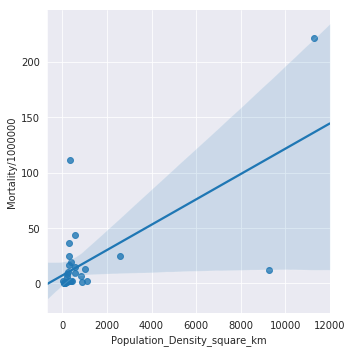

In [94]:
sns.lmplot(x='Population_Density_square_km', y='Mortality/1000000', data=latest_df)

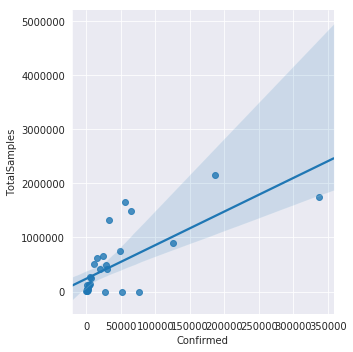

In [95]:
sns.lmplot(x='Confirmed', y='TotalSamples', data=latest_df)

In [96]:
covid_df.head()

,Date,State,Cured,Deaths,Confirmed,Active,Fatality Rate
Sno,,,,,,,
1,2020-01-30,Kerala,0,0,1,1,NaN
2,2020-01-31,Kerala,0,0,1,1,NaN
3,2020-02-01,Kerala,0,0,2,2,NaN
4,2020-02-02,Kerala,0,0,3,3,NaN
5,2020-02-03,Kerala,0,0,3,3,NaN


### Visual Analysis of most affected states

In [97]:
aggregated_df.index.get_level_values(1).unique()

Index(['West Bengal', 'Uttarakhand', 'Uttar Pradesh', 'Tripura', 'Tamil Nadu',
       'Sikkim', 'Rajasthan', 'Punjab', 'Puducherry', 'Odisha', 'Nagaland',
       'Mizoram', 'Meghalaya', 'Manipur', 'Maharashtra', 'Madhya Pradesh',
       'Kerala', 'Karnataka', 'Jharkhand', 'Himachal Pradesh', 'Haryana',
       'Gujarat', 'Goa', 'Delhi', 'Chhattisgarh', 'Chandigarh', 'Bihar',
       'Assam', 'Arunachal Pradesh', 'Andhra Pradesh'],
      dtype='object', name='State')

In [98]:
temp_df = aggregated_df.reset_index()
top_states_df = temp_df[temp_df['State'].isin(['Maharashtra', 'Gujarat', 'Tamil Nadu', 'Delhi', 'Madhya Pradesh'])].set_index(['Date', 'State']).sort_index(by='Date', ascending=True)[['Cured', 'Deaths', 'Confirmed', 'Active', 'Positive', 'TotalSamples', 'Negative']]

/home/akash/Dev/python/venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: by argument to sort_index is deprecated, please use .sort_values(by=...)
  


In [99]:
top_states_df_daily_counts = top_states_df[['TotalSamples', 'Cured', 'Confirmed', 'Deaths', 'Active', 'Negative', 'Positive']].diff().fillna(top_states_df)
top_states_df_daily_counts = top_states_df_daily_counts.query('TotalSamples > 0')
top_states_df_daily_counts = top_states_df_daily_counts.query('Confirmed > 0')

In [100]:
top_states_df_daily_counts = top_states_df_daily_counts.reset_index().set_index('Date')

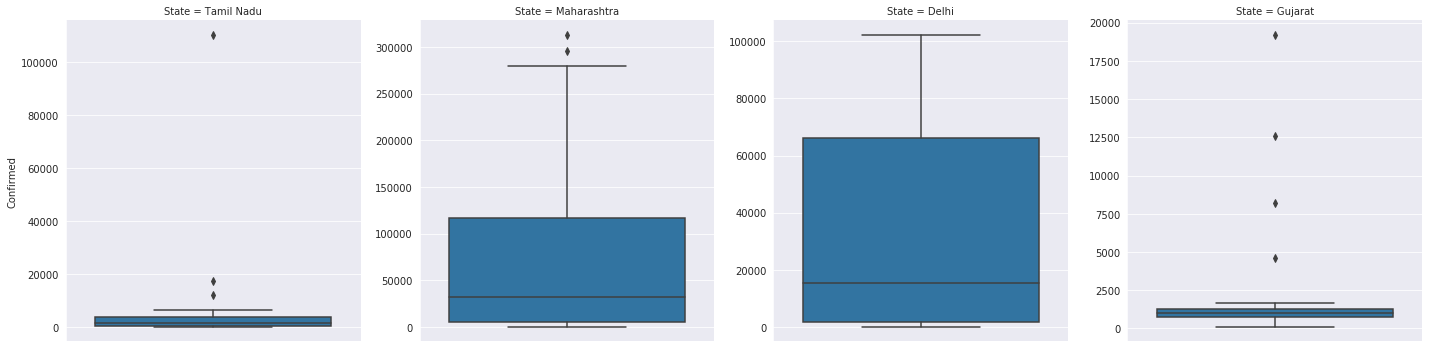

In [101]:
sns.catplot(y='Confirmed', kind='box' ,data=top_states_df_daily_counts, col='State', sharey=False)

In [102]:
top_states_df_daily_counts = top_states_df_daily_counts.reset_index().set_index(['Date', 'State'])

In [103]:
temp = top_states_df_daily_counts[top_states_df_daily_counts.Deaths > 0]
temp = temp.reset_index().set_index(['Date'])

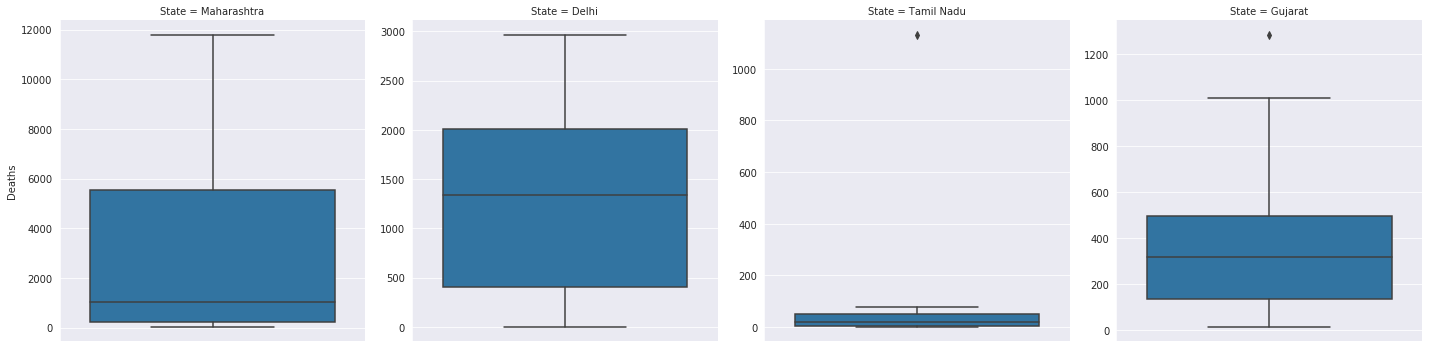

In [104]:
sns.catplot(y='Deaths', kind='box' ,data=temp, col='State', sharey=False)

In [105]:
temp = top_states_df_daily_counts[top_states_df_daily_counts.Confirmed > 0]
temp = temp.reset_index().set_index('Date')

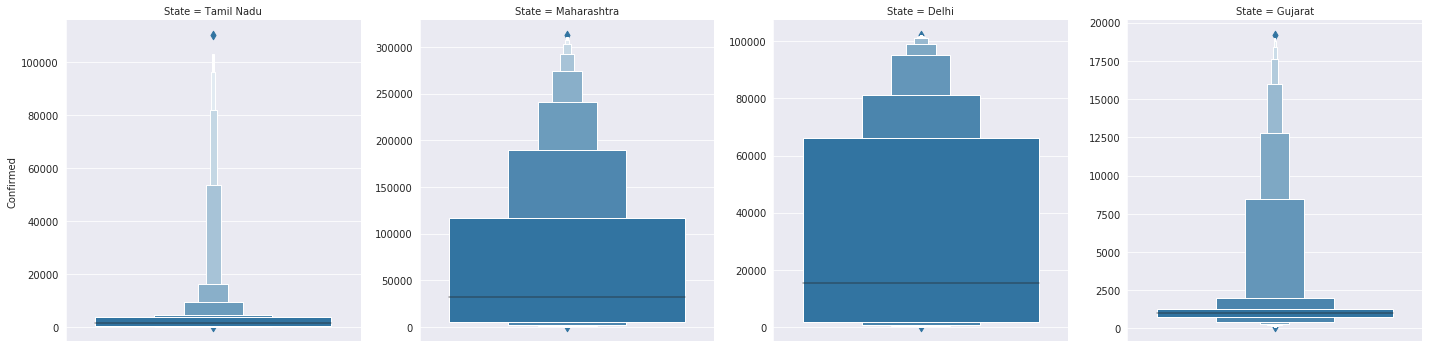

In [106]:
sns.catplot(y='Confirmed', data=temp, kind='boxen', sharey=False, col='State')

In [107]:
temp = top_states_df_daily_counts[top_states_df_daily_counts.Active > 0]
temp = temp.reset_index().set_index('Date')

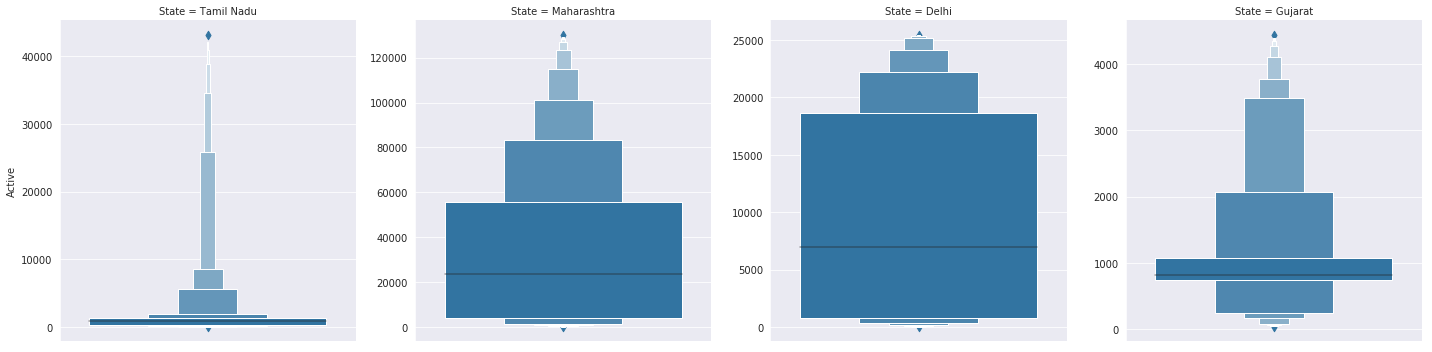

In [108]:
sns.catplot(y='Active', data=temp, kind='boxen', sharey=False, col='State')

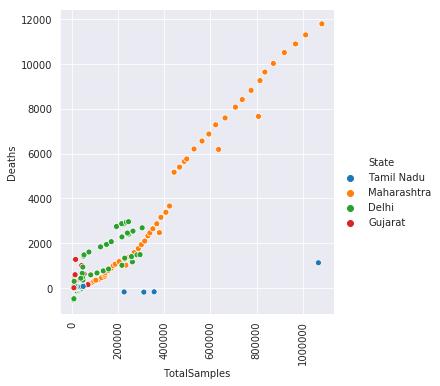

In [109]:
g = (sns.relplot(y='Deaths', x='TotalSamples', data=temp, kind='scatter', hue='State'))
plt.xticks(rotation=90)
plt.show()

#### Plot to show correlation between Confirmed Cases and Deaths

In [110]:
temp = temp.set_index('State', append=True)

In [111]:
temp = temp[(temp.values > 0).all(1)]
temp = temp.reset_index().set_index('Date')

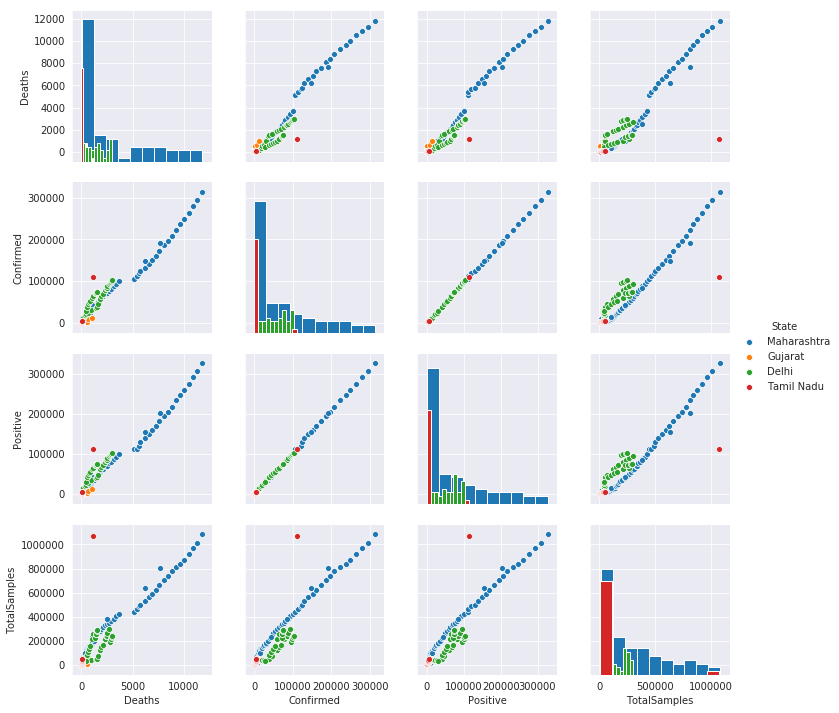

In [112]:
sns.pairplot(data=temp, vars=['Deaths', 'Confirmed', 'Positive', 'TotalSamples'], kind='scatter', diag_kind='hist', hue='State')

In [113]:
sorted_agg_df = aggregated_df.sort_index(level=0, ascending=True)

In [114]:
aggregated_df.head()

Cured  Deaths  Confirmed  Active  Fatality Rate  \
Date       State                                                             
2020-07-24 West Bengal     31656    1255      51757   18846       3.964493   
           Uttarakhand      3399      60       5445    1986       1.765225   
           Uttar Pradesh   35803    1289      58104   21012       3.600257   
           Tripura          2072      10       3656    1574       0.482625   
           Tamil Nadu     136793    3232     192964   52939       2.362694   

                          TotalSamples  Negative  Positive  Population  \
Date       State                                                         
2020-07-24 West Bengal             0.0       0.0       0.0    91276115   
           Uttarakhand             0.0       0.0       0.0    10086292   
           Uttar Pradesh           0.0       0.0       0.0   199812341   
           Tripura                 0.0       0.0       0.0     3673917   
           Tamil Nadu              0.0       0.0       0.0    72147030   

                          Rural population  Urban population  \
Date       State                                               
2020-07-24 West Bengal            62183113          29093002   
           Uttarakhand             7036954           3049338   
           Uttar Pradesh         155317278          44495063   
           Tripura                 2712464            961453   
           Tamil Nadu             37229590          34917440   

                                                Area                  Density  \
Date       State                                                                
2020-07-24 West Bengal     88,752 km2 (34,267 sq mi)  1,029/km2 (2,670/sq mi)   
           Uttarakhand     53,483 km2 (20,650 sq mi)      189/km2 (490/sq mi)   
           Uttar Pradesh  240,928 km2 (93,023 sq mi)    828/km2 (2,140/sq mi)   
           Tripura          10,486 km2 (4,049 sq mi)      350/km2 (910/sq mi)   
           Tamil Nadu     130,058 km2 (50,216 sq mi)    555/km2 (1,440/sq mi)   

                          Gender Ratio  Public Beds  Rural Beds  Urban Beds  \
Date       State                                                              
2020-07-24 West Bengal             953        51163       19684       58882   
           Uttarakhand             963         6660        3284        5228   
           Uttar Pradesh           912        58310       39104       37156   
           Tripura                 960         4895        1140        3277   
           Tamil Nadu              996        72616       40179       37353   

                          Total Beds  
Date       State                      
2020-07-24 West Bengal        129729  
           Uttarakhand         15172  
           Uttar Pradesh      134570  
           Tripura              9312  
           Tamil Nadu         150148

### Maharashtra Covid Analysis 

In [115]:
maha_df = aggregated_df.query('State == "Maharashtra"').sort_index(by='Date', ascending=True).reset_index().set_index('Date')

/home/akash/Dev/python/venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: by argument to sort_index is deprecated, please use .sort_values(by=...)
  """Entry point for launching an IPython kernel.


In [116]:
maha_df[['TotalSamples', 'Cured', 'Confirmed', 'Deaths', 'Active', 'Negative', 'Positive']].tail(10)

,TotalSamples,Cured,Confirmed,Deaths,Active,Negative,Positive
Date,,,,,,,
2020-07-15,1413185.0,149007,267665,10695,107963,1132434.0,280751.0
2020-07-16,1450129.0,152613,275640,10928,112099,1161433.0,288696.0
2020-07-17,1487738.0,158140,284281,11194,114947,1190958.0,296780.0
2020-07-18,1526037.0,160357,292589,11452,120780,1220496.0,305541.0
2020-07-19,1568229.0,165663,300937,11596,123678,1252842.0,315387.0
2020-07-20,1603802.0,169569,310455,11854,129032,1279592.0,324210.0
2020-07-21,1643981.0,175029,318695,12030,131636,1311150.0,332831.0
2020-07-22,1691546.0,182217,327031,12276,132538,1348610.0,342936.0
2020-07-23,1741992.0,187769,337607,12556,137282,1389232.0,352760.0


In [117]:
maha_df_daily_counts = maha_df[['TotalSamples', 'Cured', 'Confirmed', 'Deaths', 'Active', 'Negative', 'Positive']].diff()

In [118]:
df_t = maha_df_daily_counts.pct_change().dropna()

In [119]:
df_t = df_t[(df_t.values != np.inf).all(1)]

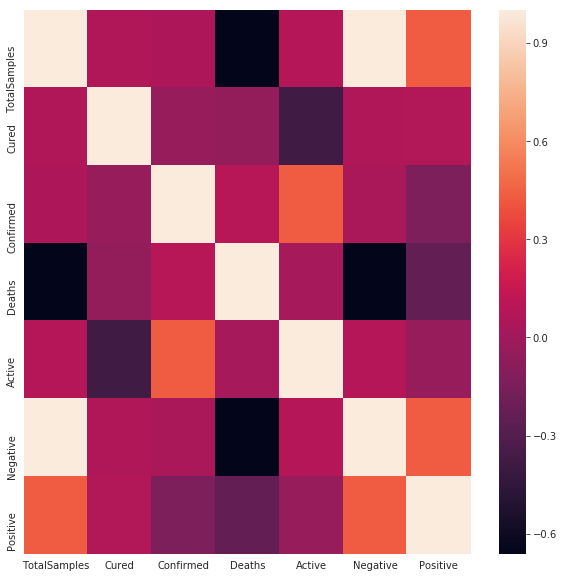

In [120]:
sns.heatmap(df_t.corr())

/home/akash/Dev/python/venv/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


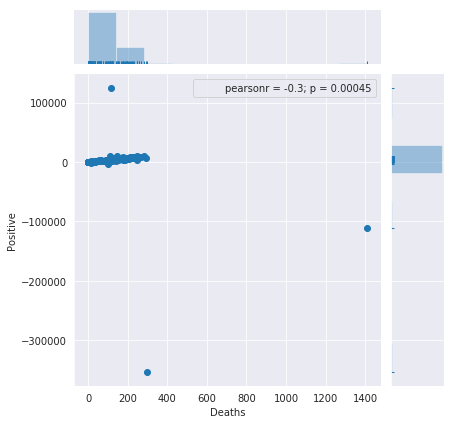

In [121]:
sns.jointplot(x='Deaths', y='Positive', data=maha_df_daily_counts, kind='scatter', marginal_kws=dict(bins=10, rug=True), stat_func=scipy.stats.pearsonr)

In [122]:
maha_df_daily_counts = maha_df_daily_counts.query('TotalSamples > 0')

In [123]:
maha_df_daily_counts.head()

,TotalSamples,Cured,Confirmed,Deaths,Active,Negative,Positive
Date,,,,,,,
2020-04-06,17563.0,14.0,258.0,21.0,223.0,16695.0,868.0
2020-04-07,3314.0,0.0,120.0,3.0,117.0,3164.0,150.0
2020-04-09,20877.0,38.0,117.0,8.0,71.0,20009.0,868.0
2020-04-10,9123.0,8.0,229.0,25.0,196.0,8856.0,267.0
2020-04-11,1841.0,63.0,210.0,13.0,134.0,1215.0,626.0


In [124]:
maha_df_daily_counts = maha_df_daily_counts.query('TotalSamples < 500000')

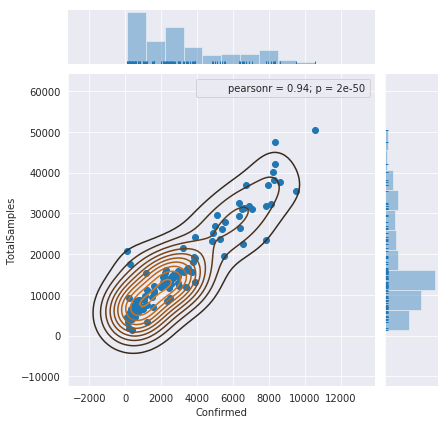

In [125]:
g = (sns.jointplot(x='Confirmed', y='TotalSamples', data=maha_df_daily_counts, kind='scatter', marginal_kws=dict(bins=10, rug=True), stat_func=scipy.stats.pearsonr)
    .plot_joint(sns.kdeplot))

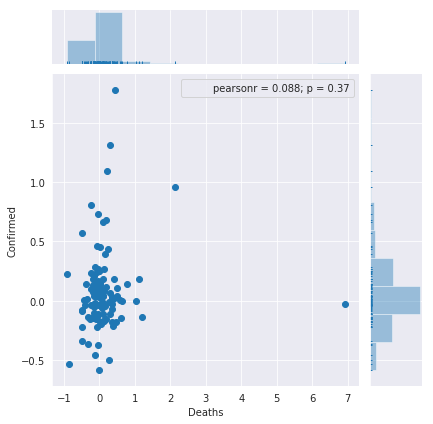

In [126]:
sns.jointplot(x='Deaths', y='Confirmed', data=df_t, kind='scatter', marginal_kws=dict(bins=10, rug=True), stat_func=scipy.stats.pearsonr)

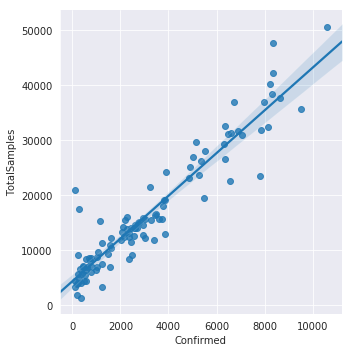

In [127]:
sns.lmplot(x='Confirmed', y='TotalSamples', data=maha_df_daily_counts)

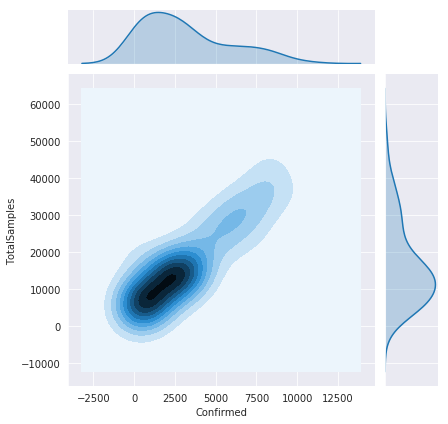

In [128]:
sns.jointplot(x='Confirmed', y='TotalSamples', data=maha_df_daily_counts, kind='kde')

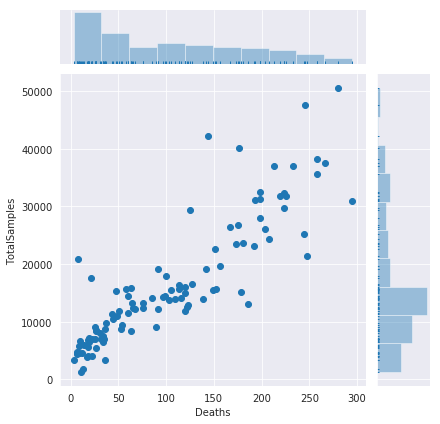

In [129]:
g = (sns.jointplot(x='Deaths', y='TotalSamples', data=maha_df_daily_counts, kind='scatter', marginal_kws=dict(bins=10, rug=True))
    )

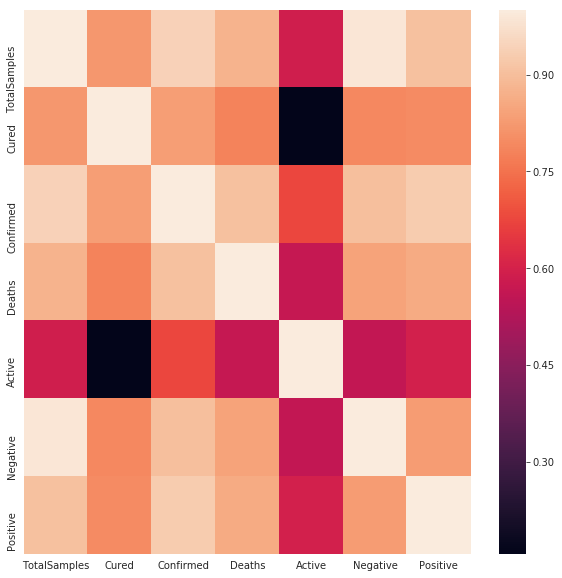

In [130]:
sns.heatmap(maha_df_daily_counts.corr())

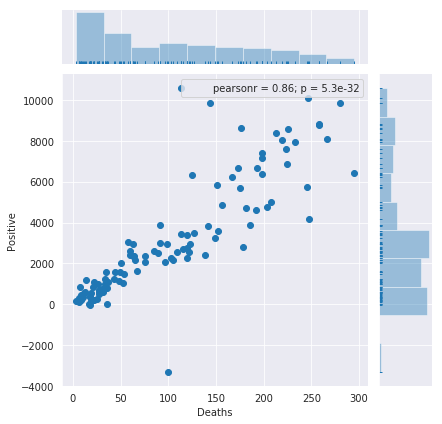

In [131]:
sns.jointplot(x='Deaths', y='Positive', data=maha_df_daily_counts, kind='scatter', marginal_kws=dict(bins=10, rug=True), stat_func=scipy.stats.pearsonr)

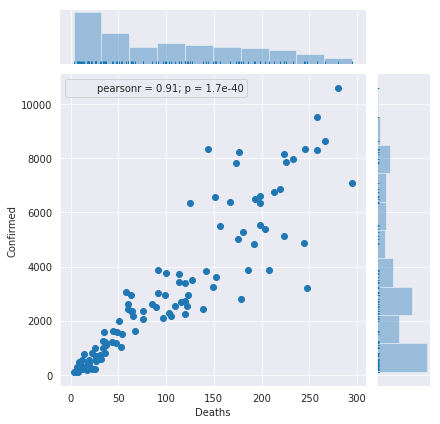

In [132]:
sns.jointplot(x='Deaths', y='Confirmed', data=maha_df_daily_counts, kind='scatter', marginal_kws=dict(bins=10, rug=True), stat_func=scipy.stats.pearsonr)

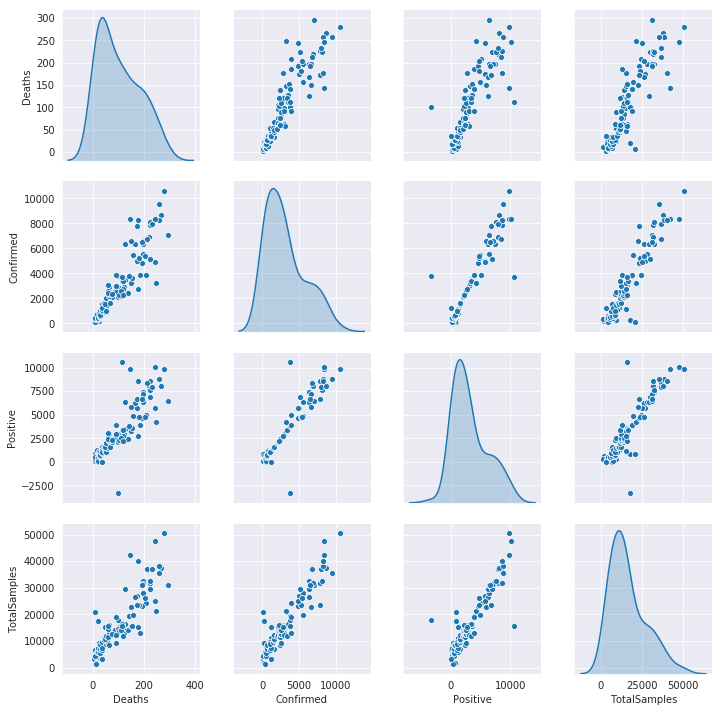

In [133]:
sns.pairplot(data=maha_df_daily_counts, vars=['Deaths', 'Confirmed', 'Positive', 'TotalSamples'], kind='scatter', diag_kind='kde')

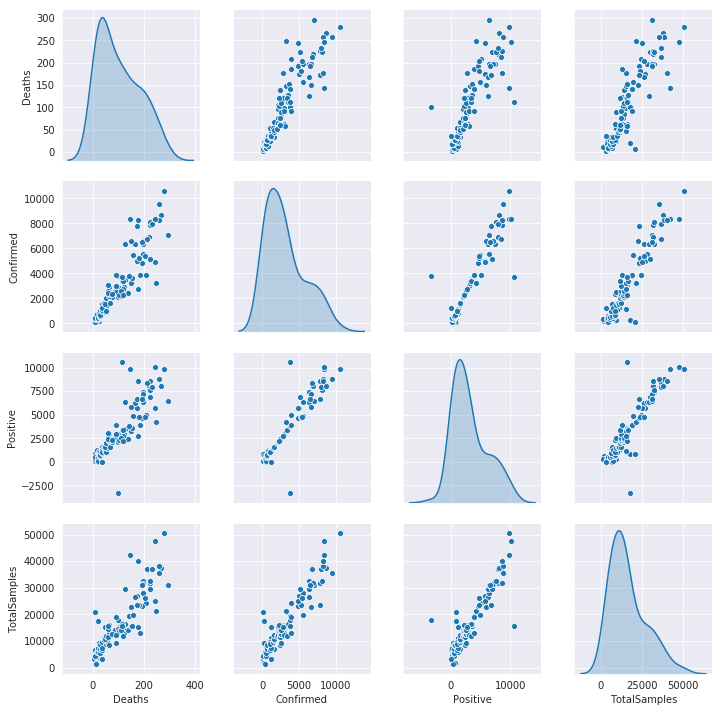

In [134]:
sns.pairplot(data=maha_df_daily_counts, vars=['Deaths', 'Confirmed', 'Positive', 'TotalSamples'], kind='scatter', diag_kind='kde', )

### % Positive Cases each Day 

In [135]:
positive_cases_df = aggregated_df[aggregated_df.TotalSamples > 0]

In [136]:
aggregated_df.shape

(3774, 18)

In [137]:
positive_cases_df.shape

(2963, 18)

In [138]:
print(f"There are {aggregated_df.shape[0] - positive_cases_df.shape[0]} records where Testing Data is not available.")

There are 811 records where Testing Data is not available.


In [139]:
positive_cases_df.head()

Cured  Deaths  Confirmed  Active  Fatality Rate  \
Date       State                                                             
2020-07-23 West Bengal     29650    1221      49321   18450       4.118044   
           Uttarakhand      3349      57       5300    1894       1.702001   
           Uttar Pradesh   33500    1263      55588   20825       3.770149   
           Tripura          2032       9       3449    1408       0.442913   
           Tamil Nadu     131583    3144     186492   51765       2.389366   

                          TotalSamples   Negative  Positive  Population  \
Date       State                                                          
2020-07-23 West Bengal        758027.0   706270.0   51757.0    91276115   
           Uttarakhand        132840.0   127395.0    5445.0    10086292   
           Uttar Pradesh     1654651.0  1596547.0   58104.0   199812341   
           Tripura            127742.0   124065.0    3677.0     3673917   
           Tamil Nadu        2157869.0  1964905.0  192964.0    72147030   

                          Rural population  Urban population  \
Date       State                                               
2020-07-23 West Bengal            62183113          29093002   
           Uttarakhand             7036954           3049338   
           Uttar Pradesh         155317278          44495063   
           Tripura                 2712464            961453   
           Tamil Nadu             37229590          34917440   

                                                Area                  Density  \
Date       State                                                                
2020-07-23 West Bengal     88,752 km2 (34,267 sq mi)  1,029/km2 (2,670/sq mi)   
           Uttarakhand     53,483 km2 (20,650 sq mi)      189/km2 (490/sq mi)   
           Uttar Pradesh  240,928 km2 (93,023 sq mi)    828/km2 (2,140/sq mi)   
           Tripura          10,486 km2 (4,049 sq mi)      350/km2 (910/sq mi)   
           Tamil Nadu     130,058 km2 (50,216 sq mi)    555/km2 (1,440/sq mi)   

                          Gender Ratio  Public Beds  Rural Beds  Urban Beds  \
Date       State                                                              
2020-07-23 West Bengal             953        51163       19684       58882   
           Uttarakhand             963         6660        3284        5228   
           Uttar Pradesh           912        58310       39104       37156   
           Tripura                 960         4895        1140        3277   
           Tamil Nadu              996        72616       40179       37353   

                          Total Beds  
Date       State                      
2020-07-23 West Bengal        129729  
           Uttarakhand         15172  
           Uttar Pradesh      134570  
           Tripura              9312  
           Tamil Nadu         150148

In [140]:
positive_cases_df['%Positive'] = (positive_cases_df['Positive'] / positive_cases_df['TotalSamples']) * 100 

/home/akash/Dev/python/venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [141]:
main_states = ['Maharashtra', 'Delhi', 'Madhya Pradesh', 'West Bengal', 'Uttar Pradesh', 'Bihar', 'Tamil Nadu']

In [142]:
top_states_positive_cases_df = positive_cases_df.loc[positive_cases_df.index.get_level_values(1).isin(main_states)]

In [143]:
maharashtra_positive_df = positive_cases_df.loc[positive_cases_df.index.get_level_values(1).isin(['Maharashtra'])]
delhi_positive_df = positive_cases_df.loc[positive_cases_df.index.get_level_values(1).isin(['Delhi'])]
tamil_nadu_positive_df = positive_cases_df.loc[positive_cases_df.index.get_level_values(1).isin(['Tamil Nadu'])]

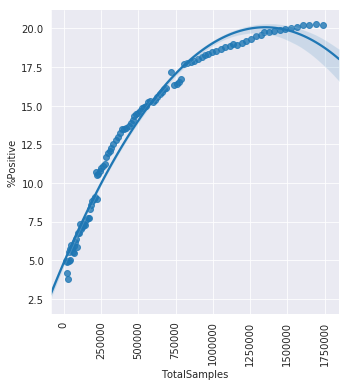

In [144]:
sns.lmplot(y='%Positive', x='TotalSamples', data=maharashtra_positive_df, order=2)
plt.xticks(rotation=90)
plt.show()

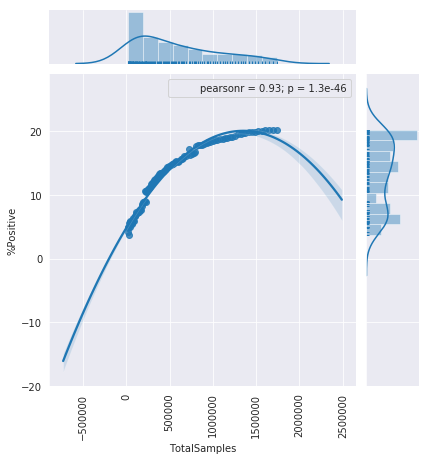

In [145]:
sns.jointplot(y='%Positive', x='TotalSamples', data=maharashtra_positive_df, kind='reg', marginal_kws=dict(bins=10, rug=True), stat_func=scipy.stats.pearsonr, order=2)
plt.xticks(rotation=90)
plt.show()

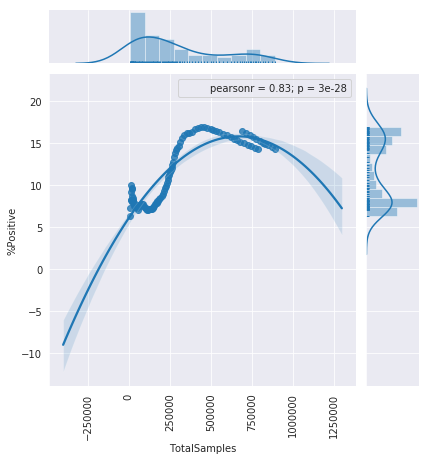

In [146]:
sns.jointplot(y='%Positive', x='TotalSamples', data=delhi_positive_df, kind='reg', marginal_kws=dict(bins=10, rug=True), stat_func=scipy.stats.pearsonr, order=2)
plt.xticks(rotation=90)
plt.show()

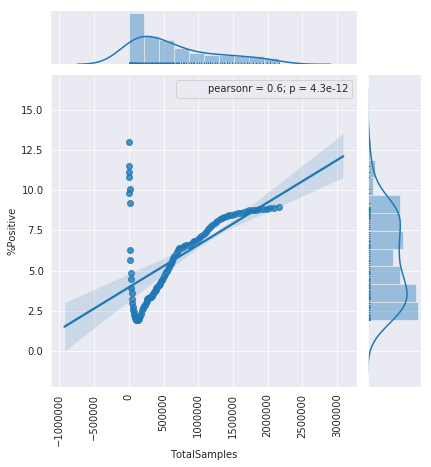

In [147]:
sns.jointplot(y='%Positive', x='TotalSamples', data=tamil_nadu_positive_df, kind='reg', marginal_kws=dict(bins=10, rug=True), stat_func=scipy.stats.pearsonr)
plt.xticks(rotation=90)
plt.show()

In [148]:
top_states_positive_cases_df = top_states_positive_cases_df.reset_index(level=1)

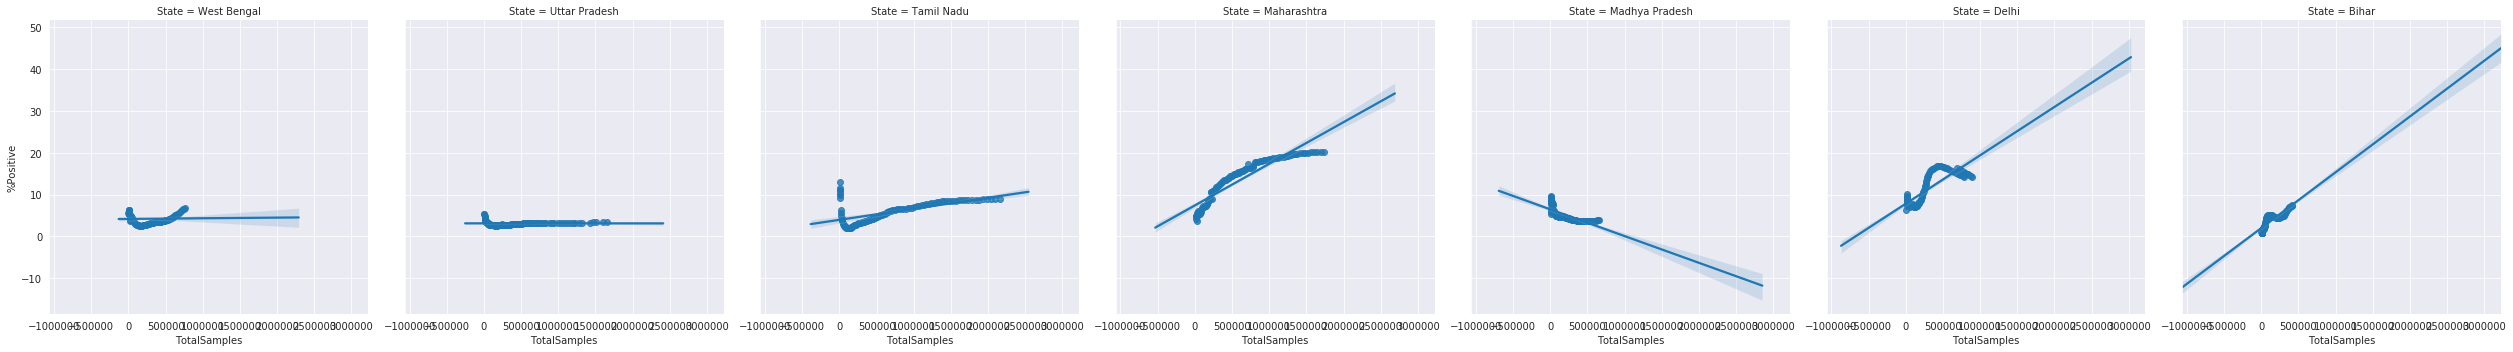

In [149]:
sns.lmplot(y='%Positive', x='TotalSamples', data=top_states_positive_cases_df, col='State', )

In [150]:
start_lockdown1 = '2020-03-25'
end_lockdown1 = '2020-04-14'
start_lockdown2 = '2020-04-15'
end_lockdown2 = '2020-05-03'
start_lockdown3 = '2020-05-04'
end_lockdown3 = '2020-05-17'
start_lockdown4 = '2020-05-18'
end_lockdown4 = '2020-05-31'
start_lockdown5 = '2020-06-01'
end_lockdown5 = '2020-06-30'
start_lockdown6 = '2020-07-01'
end_lockdown6 = report_date

### Avg Number of Tests Conducted Per Lockdown

In [151]:
start_lockdown_minus_1 = (datetime.datetime.strptime(start_lockdown1, '%Y-%m-%d') - datetime.timedelta(days=1)).strftime('%Y-%m-%d')
start_lockdown_minus_1

'2020-03-24'

In [152]:
aggregated_df.head()

Cured  Deaths  Confirmed  Active  Fatality Rate  \
Date       State                                                             
2020-07-24 West Bengal     31656    1255      51757   18846       3.964493   
           Uttarakhand      3399      60       5445    1986       1.765225   
           Uttar Pradesh   35803    1289      58104   21012       3.600257   
           Tripura          2072      10       3656    1574       0.482625   
           Tamil Nadu     136793    3232     192964   52939       2.362694   

                          TotalSamples  Negative  Positive  Population  \
Date       State                                                         
2020-07-24 West Bengal             0.0       0.0       0.0    91276115   
           Uttarakhand             0.0       0.0       0.0    10086292   
           Uttar Pradesh           0.0       0.0       0.0   199812341   
           Tripura                 0.0       0.0       0.0     3673917   
           Tamil Nadu              0.0       0.0       0.0    72147030   

                          Rural population  Urban population  \
Date       State                                               
2020-07-24 West Bengal            62183113          29093002   
           Uttarakhand             7036954           3049338   
           Uttar Pradesh         155317278          44495063   
           Tripura                 2712464            961453   
           Tamil Nadu             37229590          34917440   

                                                Area                  Density  \
Date       State                                                                
2020-07-24 West Bengal     88,752 km2 (34,267 sq mi)  1,029/km2 (2,670/sq mi)   
           Uttarakhand     53,483 km2 (20,650 sq mi)      189/km2 (490/sq mi)   
           Uttar Pradesh  240,928 km2 (93,023 sq mi)    828/km2 (2,140/sq mi)   
           Tripura          10,486 km2 (4,049 sq mi)      350/km2 (910/sq mi)   
           Tamil Nadu     130,058 km2 (50,216 sq mi)    555/km2 (1,440/sq mi)   

                          Gender Ratio  Public Beds  Rural Beds  Urban Beds  \
Date       State                                                              
2020-07-24 West Bengal             953        51163       19684       58882   
           Uttarakhand             963         6660        3284        5228   
           Uttar Pradesh           912        58310       39104       37156   
           Tripura                 960         4895        1140        3277   
           Tamil Nadu              996        72616       40179       37353   

                          Total Beds  
Date       State                      
2020-07-24 West Bengal        129729  
           Uttarakhand         15172  
           Uttar Pradesh      134570  
           Tripura              9312  
           Tamil Nadu         150148

In [153]:
df_samples = aggregated_df.loc[aggregated_df.index.get_level_values(0).isin([start_lockdown_minus_1, end_lockdown1, end_lockdown2, 
                                                                end_lockdown3, end_lockdown4,
                                                               end_lockdown5])][['TotalSamples', 'Confirmed', 'Active', 'Deaths', 'Cured', 'Positive']]

In [154]:
df_samples = df_samples.reset_index(level=1)

In [155]:
df_samples['%Positive'] = df_samples['Positive'] / df_samples['TotalSamples'] * 100

In [156]:
df_samples.head()

,State,TotalSamples,Confirmed,Active,Deaths,Cured,Positive,%Positive
Date,,,,,,,,
2020-06-30,West Bengal,488038.0,17907,5535,653,11719,18559.0,3.802778
2020-06-30,Uttarakhand,69024.0,2831,681,39,2111,2881.0,4.173911
2020-06-30,Uttar Pradesh,727793.0,22828,6650,672,15506,23492.0,3.227841
2020-06-30,Tripura,64478.0,1380,294,1,1085,1393.0,2.160427
2020-06-30,Tamil Nadu,1170683.0,86224,37334,1141,47749,90167.0,7.702085


In [157]:
unique_states = set(df_samples['State'])

In [158]:
df_samples[df_samples.State == 'Delhi']

,State,TotalSamples,Confirmed,Active,Deaths,Cured,Positive,%Positive
Date,,,,,,,,
2020-06-30,Delhi,531752.0,85161,26246,2680,56235,87360.0,16.428711
2020-05-31,Delhi,212784.0,18549,10058,416,8075,19844.0,9.325889
2020-05-17,Delhi,135791.0,9333,5278,129,3926,9755.0,7.183834
2020-05-03,Delhi,60246.0,4122,2802,64,1256,4549.0,7.550709
2020-04-14,Delhi,16282.0,1510,1452,28,30,1561.0,9.587274
2020-03-24,Delhi,0.0,30,23,1,6,0.0,NaN


In [159]:
d2 = df_samples[df_samples.State == 'Delhi'].set_index('State', append=True).diff().dropna()[['TotalSamples']].apply(np.abs)
d3 = df_samples[df_samples.State == 'Maharashtra'].set_index('State', append=True).diff().dropna()[['TotalSamples']].apply(np.abs)

In [160]:
pd.concat([d2, d3])

,,TotalSamples
Date,State,
2020-05-31,Delhi,318968.0
2020-05-17,Delhi,76993.0
2020-05-03,Delhi,75545.0
2020-04-14,Delhi,43964.0
2020-05-31,Maharashtra,506984.0
2020-05-17,Maharashtra,189137.0
2020-05-03,Maharashtra,114286.0
2020-04-14,Maharashtra,118683.0


In [161]:
df_samples_final = pd.DataFrame()

for state in main_states:
    d = df_samples[df_samples.State == state].set_index('State', append=True).diff().dropna()[['TotalSamples', 'Confirmed', 'Active', 'Deaths', 'Cured', '%Positive']].apply(np.abs)
    df_samples_final = pd.concat([df_samples_final, d])


In [162]:
dft = df_samples_final.reset_index(level=1)
dft.index = dft.index.astype(str)

In [163]:
date_to_lockdown_number_map = {"2020-05-31": "Lockdown5", "2020-05-17": "Lockdown4", "2020-05-03": "Lockdown3", "2020-04-14": "Lockdown2", "2020-03-24": "Lockdown1"}

In [164]:
list_lockdown_number = list(dft.index.map(lambda val: date_to_lockdown_number_map[str(val)]))

In [165]:
df_samples_final.loc[:, 'Lockdown_Number'] = list_lockdown_number

In [166]:
df_samples_final = df_samples_final.reset_index(level=1)
df_samples_final = df_samples_final.sort_values(by='Lockdown_Number')

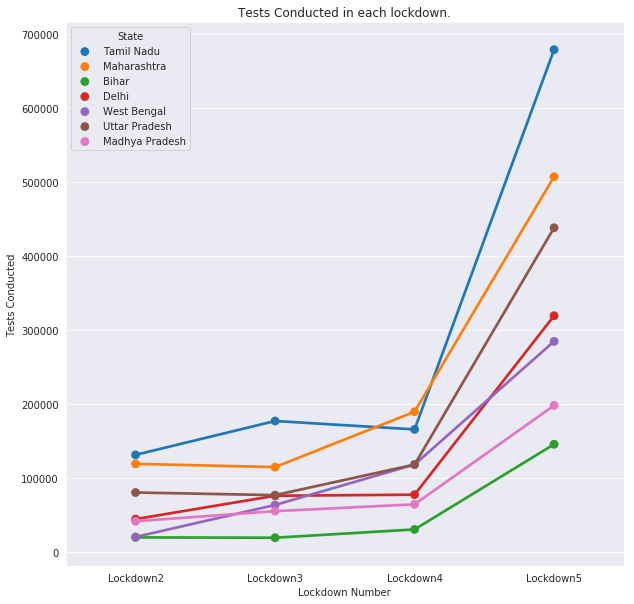

In [167]:
sns.pointplot(hue='State', 
            data=df_samples_final, 
            y='TotalSamples',
            x='Lockdown_Number')
plt.ylabel('Tests Conducted')
plt.xlabel('Lockdown Number')
plt.title('Tests Conducted in each lockdown.')
plt.show()

### The two plots below explain the reason behind recent surge in number of cases  

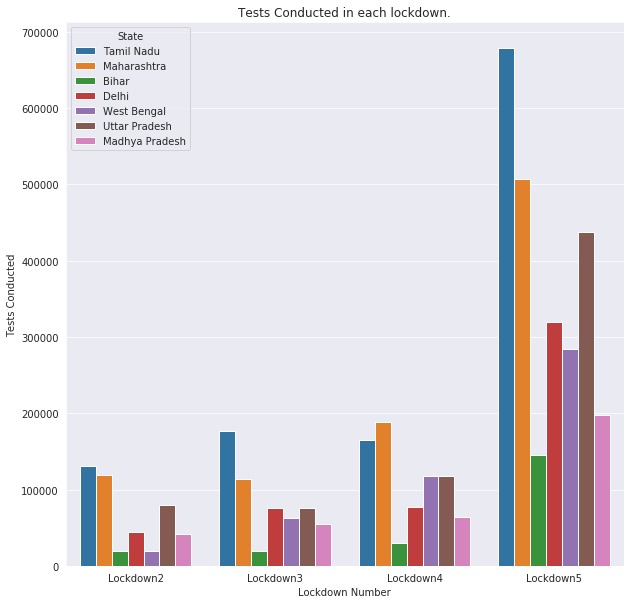

In [168]:
sns.barplot(hue='State', 
            data=df_samples_final, 
            y='TotalSamples',
            x='Lockdown_Number')
plt.ylabel('Tests Conducted')
plt.xlabel('Lockdown Number')
plt.title('Tests Conducted in each lockdown.')
plt.show()

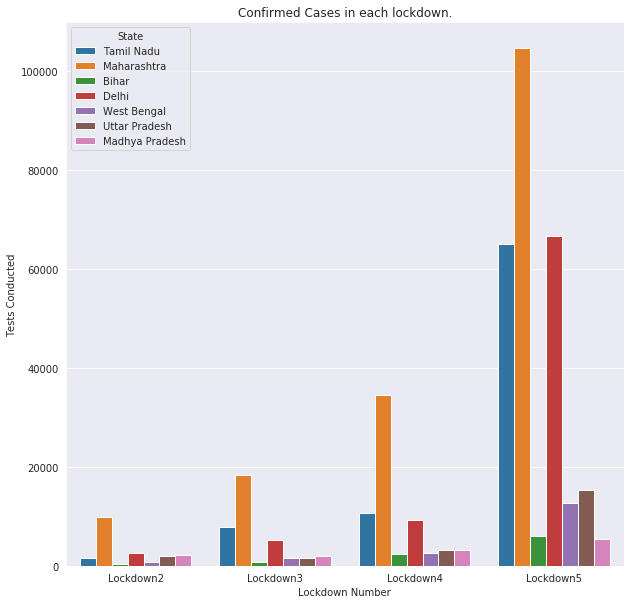

In [169]:
sns.barplot(hue='State', 
            data=df_samples_final, 
            y='Confirmed',
            x='Lockdown_Number')
plt.ylabel('Tests Conducted')
plt.xlabel('Lockdown Number')
plt.title('Confirmed Cases in each lockdown.')
plt.show()

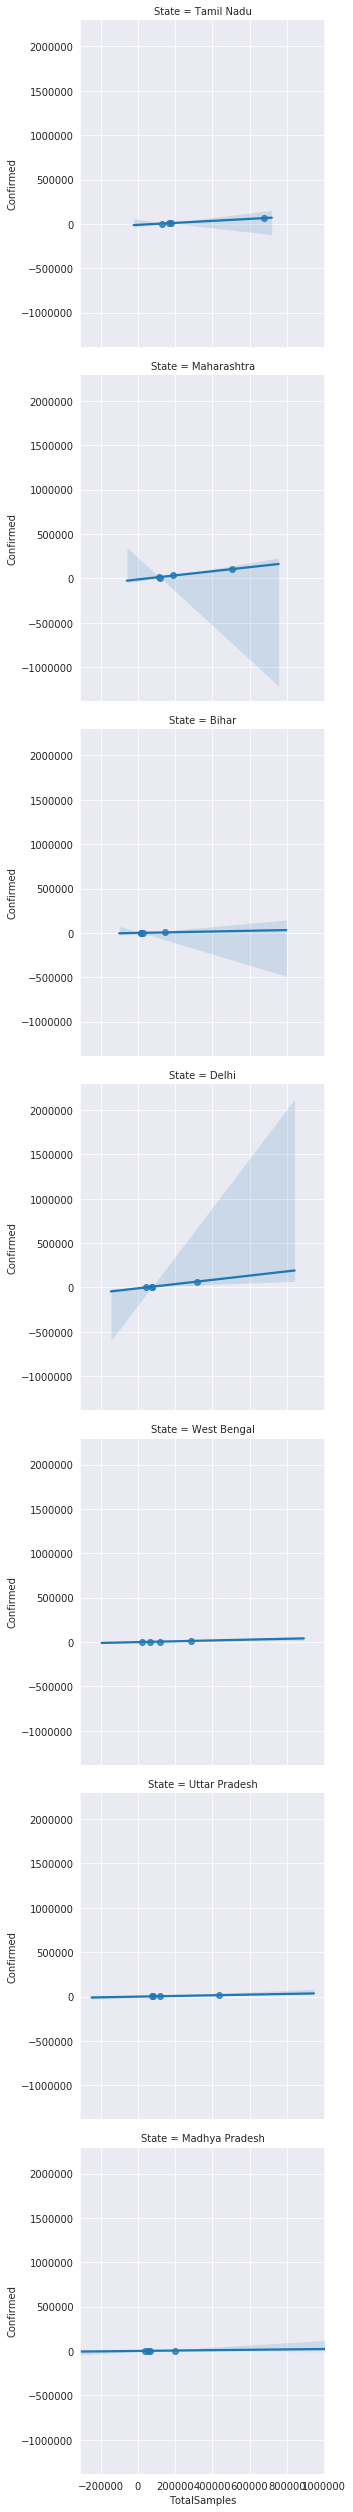

In [170]:
sns.lmplot(y='Confirmed', x='TotalSamples', data=df_samples_final, row='State')

In [171]:
df_tmp = top_states_positive_cases_df.reset_index()

### The plots below illustrates how % positive cases are surging with increase Tests being conducted.

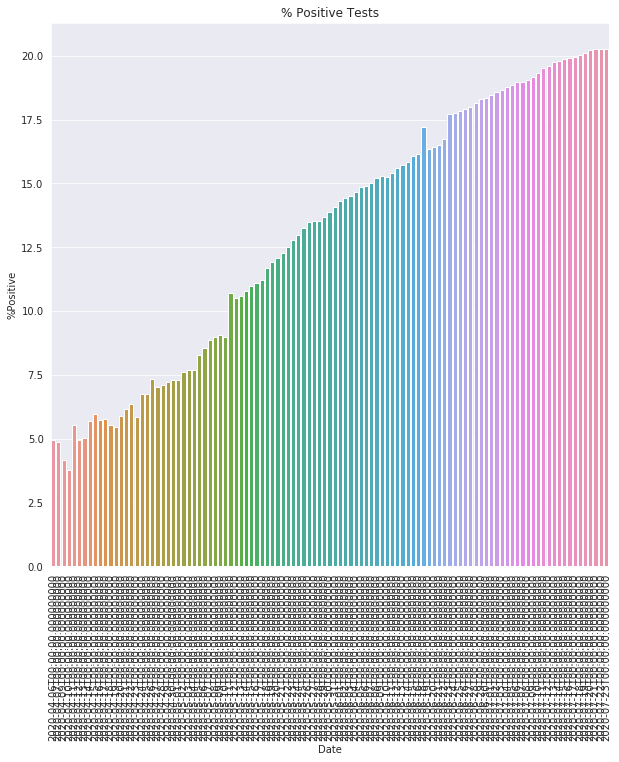

In [172]:
sns.barplot(x='Date', y='%Positive', data=df_tmp[df_tmp.State == 'Maharashtra'])
plt.xticks(rotation=90)
plt.title('% Positive Tests')
plt.show()

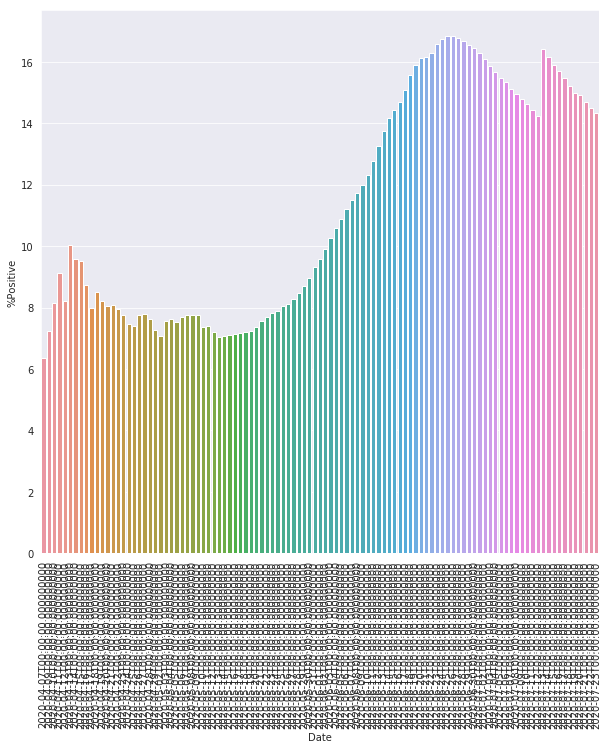

In [173]:
sns.barplot(x='Date', y='%Positive', data=df_tmp[df_tmp.State == 'Delhi'])
plt.xticks(rotation=90)
plt.show()

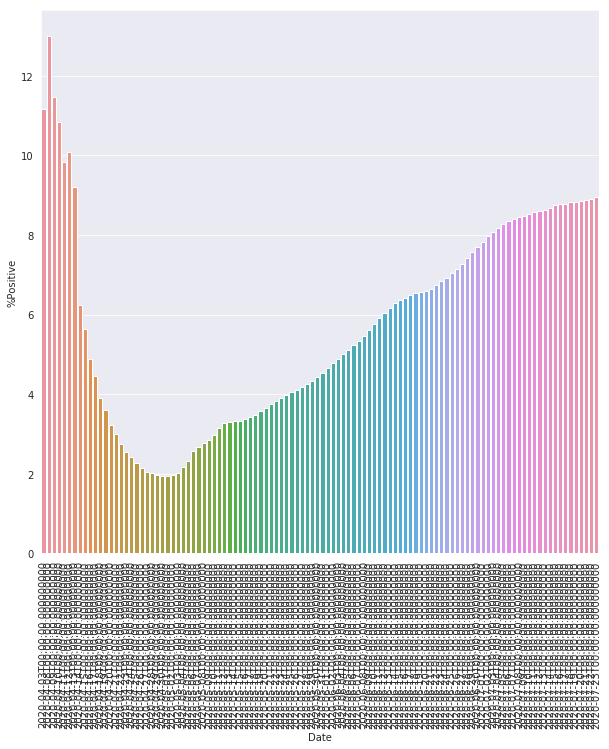

In [174]:
sns.barplot(x='Date', y='%Positive', data=df_tmp[df_tmp.State == 'Tamil Nadu'])
plt.xticks(rotation=90)
plt.show()

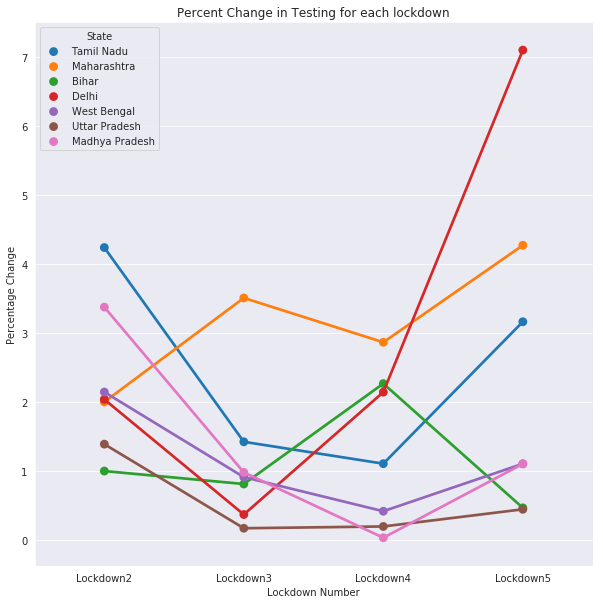

In [175]:
sns.pointplot(hue='State', 
            data=df_samples_final, 
            y='%Positive',
            x='Lockdown_Number')
plt.ylabel('Percentage Change')
plt.xlabel('Lockdown Number')
plt.title('Percent Change in Testing for each lockdown')
plt.show()

### Analyzing Each Lockdown 

In [176]:
lockdown1_df = aggregated_df.loc[(aggregated_df.index.get_level_values(0) >= start_lockdown1) & (aggregated_df.index.get_level_values(0) <= end_lockdown1)]
lockdown2_df = aggregated_df.loc[(aggregated_df.index.get_level_values(0) >= start_lockdown2) & (aggregated_df.index.get_level_values(0) <= end_lockdown2)]
lockdown3_df = aggregated_df.loc[(aggregated_df.index.get_level_values(0) >= start_lockdown3) & (aggregated_df.index.get_level_values(0) <= end_lockdown3)]
lockdown4_df = aggregated_df.loc[(aggregated_df.index.get_level_values(0) >= start_lockdown4) & (aggregated_df.index.get_level_values(0) <= end_lockdown4)]
lockdown5_df = aggregated_df.loc[(aggregated_df.index.get_level_values(0) >= start_lockdown5) & (aggregated_df.index.get_level_values(0) <= end_lockdown5)]
lockdown6_df = aggregated_df.loc[(aggregated_df.index.get_level_values(0) >= start_lockdown6) & (aggregated_df.index.get_level_values(0) <= end_lockdown6)]

In [177]:
df1 = lockdown1_df.loc[lockdown1_df.index.get_level_values(0).isin([start_lockdown1, end_lockdown1])][['Confirmed', 'Deaths', 'Cured', 'Active', 'TotalSamples']]
df1 = df1.unstack(0)[['Confirmed']].dropna()
df1.columns = df1.columns.droplevel(0)
df1.columns= df1.columns.astype(str)
df1['pct_increase1'] = (df1[end_lockdown1] - df1[start_lockdown1]) / df1[start_lockdown1] * 100
df1 = df1.sort_values(by='pct_increase1', ascending=False)
df_temp1 = df1.reset_index()
df_temp1[df_temp1.State.isin(['Maharashtra', 'Delhi', 'West Bengal', 'Madhya Pradesh', 'Gujarat'])]

Date,State,2020-04-14,2020-03-25,pct_increase1
2,Madhya Pradesh,730.0,14.0,5114.285714
3,Delhi,1510.0,31.0,4770.967742
7,West Bengal,190.0,9.0,2011.111111
8,Maharashtra,2337.0,128.0,1725.781250
11,Gujarat,617.0,38.0,1523.684211


In [178]:
df2 = lockdown2_df.loc[lockdown2_df.index.get_level_values(0).isin([start_lockdown2, end_lockdown2])][['Confirmed', 'Deaths', 'Cured', 'Active', 'TotalSamples']]
df2 = df2.unstack(0)[['Confirmed']].dropna()
df2.columns = df2.columns.droplevel(0)
df2.columns= df2.columns.astype(str)
df2['pct_increase2'] = (df2[end_lockdown2] - df2[start_lockdown2]) / df2[start_lockdown2] * 100
df2 = df2.sort_values(by='pct_increase2', ascending=False)
df_temp2 = df2.reset_index()
df_temp2[df_temp2.State.isin(['Maharashtra', 'Delhi', 'West Bengal', 'Madhya Pradesh', 'Gujarat'])]

Date,State,2020-05-03,2020-04-15,pct_increase2
0,Gujarat,5055.0,695.0,627.338129
2,Maharashtra,12296.0,2687.0,357.610718
4,West Bengal,922.0,213.0,332.863850
9,Madhya Pradesh,2846.0,987.0,188.348531
12,Delhi,4122.0,1561.0,164.061499


In [179]:
df3 = lockdown3_df.loc[lockdown3_df.index.get_level_values(0).isin([start_lockdown3, end_lockdown3])][['Confirmed', 'Deaths', 'Cured', 'Active', 'TotalSamples']]
df3 = df3.unstack(0)[['Confirmed']].dropna()
df3.columns = df3.columns.droplevel(0)
df3.columns= df3.columns.astype(str)
df3['pct_increase3'] = (df3[end_lockdown3] - df3[start_lockdown3]) / df3[start_lockdown3] * 100
df3 = df3.sort_values(by='pct_increase3', ascending=False)
df_temp3 = df3.reset_index()
df_temp3[df_temp3.State.isin(['Maharashtra', 'Delhi', 'West Bengal', 'Madhya Pradesh', 'Gujarat'])]

Date,State,2020-05-17,2020-05-04,pct_increase3
4,West Bengal,2576,963,167.497404
6,Maharashtra,30706,12974,136.673347
9,Delhi,9333,4549,105.165971
11,Gujarat,10988,5428,102.431835
18,Madhya Pradesh,4789,2942,62.780421


In [180]:
df4 = lockdown4_df.loc[lockdown4_df.index.get_level_values(0).isin([start_lockdown4, end_lockdown4])][['Confirmed', 'Deaths', 'Cured', 'Active', 'TotalSamples']]
df4 = df4.unstack(0)[['Confirmed']].dropna()
df4.columns = df4.columns.droplevel(0)
df4.columns= df4.columns.astype(str)
df4['pct_increase4'] = (df4[end_lockdown4] - df4[start_lockdown4]) / df4[start_lockdown4] * 100
df4 = df4.sort_values(by='pct_increase4', ascending=False)
df_temp4 = df4.reset_index()
df_temp4[df_temp4.State.isin(['Maharashtra', 'Delhi', 'West Bengal', 'Madhya Pradesh', 'Gujarat'])]

Date,State,2020-05-31,2020-05-18,pct_increase4
15,Maharashtra,65168.0,33053.0,97.162134
16,West Bengal,5130.0,2677.0,91.632424
18,Delhi,18549.0,10054.0,84.493734
22,Madhya Pradesh,7891.0,4977.0,58.549327
25,Gujarat,16343.0,11379.0,43.624220


In [181]:
lockdown5_df.tail()

Cured  Deaths  Confirmed  Active  Fatality Rate  \
Date       State                                                                
2020-06-01 Chandigarh           199       4        293      90       2.010050   
           Bihar               1710      21       3815    2084       1.228070   
           Assam                185       4       1272    1083       2.162162   
           Arunachal Pradesh      1       0          4       3       0.000000   
           Andhra Pradesh      2349      62       3679    1268       2.639421   

                              TotalSamples  Negative  Positive  Population  \
Date       State                                                             
2020-06-01 Chandigarh               4816.0    4522.0     294.0     1055450   
           Bihar                   78090.0   74218.0    3872.0   104099452   
           Assam                       0.0       0.0       0.0    31205576   
           Arunachal Pradesh        8768.0    8746.0      22.0     1383727   
           Andhra Pradesh         383315.0  380197.0    3118.0    49577103   

                              Rural population  Urban population  \
Date       State                                                   
2020-06-01 Chandigarh                    28991           1026459   
           Bihar                      92341436          11758016   
           Assam                      26807034           4398542   
           Arunachal Pradesh           1066358            317369   
           Andhra Pradesh             34966693          14610410   

                                                    Area  \
Date       State                                           
2020-06-01 Chandigarh                 114 km2 (44 sq mi)   
           Bihar               94,163 km2 (36,357 sq mi)   
           Assam               78,438 km2 (30,285 sq mi)   
           Arunachal Pradesh   83,743 km2 (32,333 sq mi)   
           Andhra Pradesh     162,968 km2 (62,922 sq mi)   

                                               Density  Gender Ratio  \
Date       State                                                       
2020-06-01 Chandigarh         9,252/km2 (23,960/sq mi)           818   
           Bihar               1,102/km2 (2,850/sq mi)           918   
           Assam                 397/km2 (1,030/sq mi)           954   
           Arunachal Pradesh         17/km2 (44/sq mi)           938   
           Andhra Pradesh          303/km2 (780/sq mi)           993   

                              Public Beds  Rural Beds  Urban Beds  Total Beds  
Date       State                                                               
2020-06-01 Chandigarh                3756           0         778        4534  
           Bihar                    17796        6083        5936       29815  
           Assam                    19115       10944        6198       36257  
           Arunachal Pradesh         2320        2136         268        4724  
           Andhra Pradesh           60799        6480       16658       83937

In [182]:
df5 = lockdown5_df.loc[lockdown5_df.index.get_level_values(0).isin([start_lockdown5, end_lockdown5])][['Confirmed', 'Deaths', 'Cured', 'Active', 'TotalSamples']]
df5 = df5.unstack(0)[['Confirmed']].dropna()
df5.columns = df5.columns.droplevel(0)
df5.columns= df5.columns.astype(str)
df5['pct_increase5'] = (df5[end_lockdown5] - df5[start_lockdown5]) / df5[start_lockdown5] * 100
df5 = df5.sort_values(by='pct_increase5', ascending=False)
df_temp5 = df5.reset_index()
df_temp5[df_temp5.State.isin(['Maharashtra', 'Delhi', 'West Bengal', 'Madhya Pradesh', 'Gujarat'])]

Date,State,2020-06-30,2020-06-01,pct_increase5
12,Delhi,85161,19844,329.152389
18,West Bengal,17907,5501,225.522632
23,Maharashtra,169883,67655,151.101914
26,Gujarat,31938,16779,90.345074
28,Madhya Pradesh,13370,8089,65.286191


In [183]:
df6 = lockdown6_df.loc[lockdown6_df.index.get_level_values(0).isin([start_lockdown6, end_lockdown6])][['Confirmed', 'Deaths', 'Cured', 'Active', 'TotalSamples']]
df6 = df6.unstack(0)[['Confirmed']].dropna()
df6.columns = df6.columns.droplevel(0)
df6.columns= df6.columns.astype(str)
df6['pct_increase6'] = (df6[end_lockdown6] - df6[start_lockdown6]) / df6[start_lockdown6] * 100
df6 = df6.sort_values(by='pct_increase6', ascending=False)
df_temp6 = df6.reset_index()
df_temp6[df_temp6.State.isin(['Maharashtra', 'Delhi', 'West Bengal', 'Madhya Pradesh', 'Gujarat'])]

Date,State,2020-07-23,2020-07-01,pct_increase6
11,West Bengal,49321,18559,165.752465
21,Maharashtra,337607,174761,93.182117
23,Madhya Pradesh,24842,13593,82.755830
28,Gujarat,51399,32557,57.873883
29,Delhi,126323,87360,44.600504


In [184]:
df_list = [df_temp1, df_temp2, df_temp3, df_temp4, df_temp5, df_temp6]

In [185]:
from functools import reduce

In [186]:
df_final = reduce(lambda left,right: pd.merge(left,right,on='State'), df_list)

In [187]:
columns = ["State", "%Change", "Lockdown_Number"]
list_of_values = []

In [188]:
df_final[df_final.State.isin(main_states)]

Date,State,2020-04-14,2020-03-25,pct_increase1,2020-05-03,2020-04-15,pct_increase2,2020-05-17,2020-05-04,pct_increase3,2020-05-31,2020-05-18,pct_increase4,2020-06-30,2020-06-01,pct_increase5,2020-07-23,2020-07-01,pct_increase6
0,Tamil Nadu,1173.0,18.0,6416.666667,2757.0,1204.0,128.986711,10585,3023,250.148859,21184.0,11224.0,88.738418,86224,22333,286.083374,186492,90167,106.829550
2,Madhya Pradesh,730.0,14.0,5114.285714,2846.0,987.0,188.348531,4789,2942,62.780421,7891.0,4977.0,58.549327,13370,8089,65.286191,24842,13593,82.755830
3,Delhi,1510.0,31.0,4770.967742,4122.0,1561.0,164.061499,9333,4549,105.165971,18549.0,10054.0,84.493734,85161,19844,329.152389,126323,87360,44.600504
7,West Bengal,190.0,9.0,2011.111111,922.0,213.0,332.863850,2576,963,167.497404,5130.0,2677.0,91.632424,17907,5501,225.522632,49321,18559,165.752465
8,Maharashtra,2337.0,128.0,1725.781250,12296.0,2687.0,357.610718,30706,12974,136.673347,65168.0,33053.0,97.162134,169883,67655,151.101914,337607,174761,93.182117
9,Uttar Pradesh,657.0,37.0,1675.675676,2626.0,735.0,257.278912,4258,2742,55.288111,7445.0,4259.0,74.806293,22828,7823,191.806212,55588,23492,136.625234
10,Bihar,66.0,4.0,1550.000000,482.0,70.0,588.571429,1179,517,128.046422,3636.0,1262.0,188.114105,9640,3815,152.686763,30369,10043,202.389724


#### Preparing Data for Visualizing Per Lockdown Analysis 

In [189]:
list_of_values = []
for index, values in df_final[df_final.State.isin(main_states)].iterrows():
    l1 = []
    l2 = []
    l3 = []
    l4 = []
    l5 = []
    l6 = []

    l1.append(values['State'])
    l1.append(values['pct_increase1'])
    l1.append("Lockdown1")
    
    l2.append(values['State'])
    l2.append(values['pct_increase2'])
    l2.append("Lockdown2")
    
    l3.append(values['State'])
    l3.append(values['pct_increase3'])
    l3.append("Lockdown3")
    
    l4.append(values['State'])
    l4.append(values['pct_increase4'])
    l4.append("Lockdown4")
    
    l5.append(values['State'])
    l5.append(values['pct_increase5'])
    l5.append("Lockdown5")
    
    l6.append(values['State'])
    l6.append(values['pct_increase6'])
    l6.append("Lockdown6")
    
    list_of_values.append(l1)
    list_of_values.append(l2)
    list_of_values.append(l3)
    list_of_values.append(l4)
    list_of_values.append(l5)
    list_of_values.append(l6)

In [190]:
df_lockdown_analysis = pd.DataFrame(list_of_values, columns=columns)

#### Percentage Change in Confirmed Cases for Main States per lockdown 

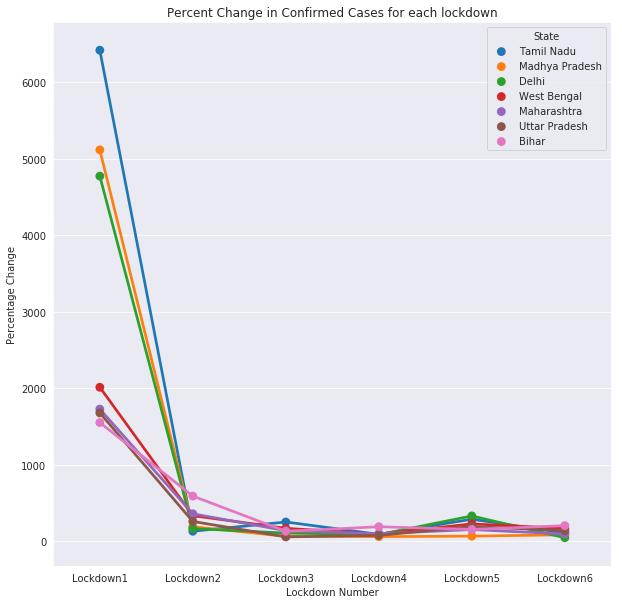

In [191]:
sns.pointplot(hue='State', 
            data=df_lockdown_analysis, 
            y='%Change',
            x='Lockdown_Number')
plt.ylabel('Percentage Change')
plt.xlabel('Lockdown Number')
plt.title('Percent Change in Confirmed Cases for each lockdown')
plt.show()

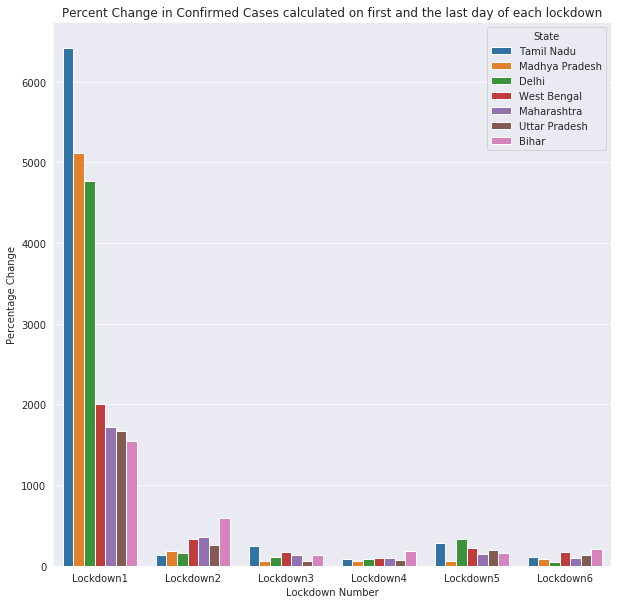

In [192]:
sns.barplot(hue='State', 
            data=df_lockdown_analysis, 
            y='%Change',
            x='Lockdown_Number')
plt.ylabel('Percentage Change')
plt.xlabel('Lockdown Number')
plt.title('Percent Change in Confirmed Cases calculated on first and the last day of each lockdown')
plt.show()

In [193]:
df_pct_inc = df_final[df_final.State.isin(['Maharashtra', 'Delhi', 'West Bengal', 'Madhya Pradesh', 'Gujarat', 'Tamil Nadu'])][['State', 'pct_increase1', 'pct_increase2', 'pct_increase3', 'pct_increase4', 'pct_increase5']]

In [194]:
df_pct_inc['avg_pct_inc'] = (df_pct_inc['pct_increase1'] + df_pct_inc['pct_increase2'] 
                            + df_pct_inc['pct_increase3'] + df_pct_inc['pct_increase4'] + df_pct_inc['pct_increase5']) / 5

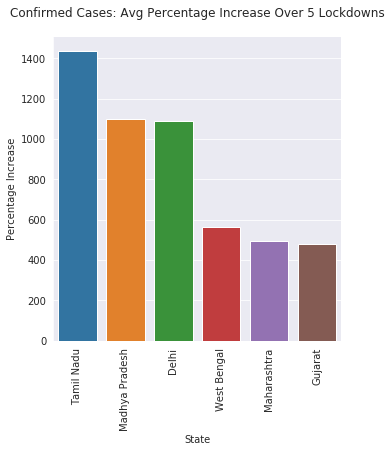

In [195]:
sns.catplot(x='State', y='avg_pct_inc', data=df_pct_inc, kind='bar')
plt.xticks(rotation=90)
plt.ylabel('Percentage Increase')
plt.title('Confirmed Cases: Avg Percentage Increase Over 5 Lockdowns', pad=20)
plt.show()

### Recovery Rate for State per lockdown

In [196]:
df1 = lockdown1_df.loc[lockdown1_df.index.get_level_values(0).isin([start_lockdown1, end_lockdown1])][['Confirmed', 'Deaths', 'Cured', 'Active', 'TotalSamples']]
df1 = df1.unstack(0)[['Cured']].dropna()
df1.columns = df1.columns.droplevel(0)
df1.columns= df1.columns.astype(str)
df1['pct_increase1'] = (df1[end_lockdown1] - df1[start_lockdown1]) / df1[start_lockdown1] * 100
df1 = df1.sort_values(by='pct_increase1', ascending=False)
df_temp1 = df1.reset_index()
df_temp1[df_temp1.State.isin(main_states)]

Date,State,2020-04-14,2020-03-25,pct_increase1
0,West Bengal,36.0,0.0,inf
2,Bihar,26.0,0.0,inf
8,Madhya Pradesh,51.0,0.0,inf
12,Maharashtra,229.0,1.0,2.280000e+04
13,Tamil Nadu,58.0,1.0,5.700000e+03
18,Delhi,30.0,6.0,4.000000e+02
19,Uttar Pradesh,49.0,11.0,3.454545e+02


In [197]:
df2 = lockdown2_df.loc[lockdown2_df.index.get_level_values(0).isin([start_lockdown2, end_lockdown2])][['Confirmed', 'Deaths', 'Cured', 'Active', 'TotalSamples']]
df2 = df2.unstack(0)[['Cured']].dropna()
df2.columns = df2.columns.droplevel(0)
df2.columns= df2.columns.astype(str)
df2['pct_increase2'] = (df2[end_lockdown2] - df2[start_lockdown2]) / df2[start_lockdown2] * 100
df2 = df2.sort_values(by='pct_increase2', ascending=False)
df_temp2 = df2.reset_index()
df_temp2[df_temp2.State.isin(main_states)]

Date,State,2020-05-03,2020-04-15,pct_increase2
4,Delhi,1256.0,30.0,4086.666667
6,Tamil Nadu,1341.0,81.0,1555.555556
8,Uttar Pradesh,698.0,51.0,1268.627451
9,Madhya Pradesh,798.0,64.0,1146.875000
11,Maharashtra,2000.0,259.0,672.200772
16,West Bengal,151.0,37.0,308.108108
17,Bihar,117.0,29.0,303.448276


In [198]:
df3 = lockdown3_df.loc[lockdown3_df.index.get_level_values(0).isin([start_lockdown3, end_lockdown3])][['Confirmed', 'Deaths', 'Cured', 'Active', 'TotalSamples']]
df3 = df3.unstack(0)[['Cured']].dropna()
df3.columns = df3.columns.droplevel(0)
df3.columns= df3.columns.astype(str)
df3['pct_increase3'] = (df3[end_lockdown3] - df3[start_lockdown3]) / df3[start_lockdown3] * 100
df3 = df3.sort_values(by='pct_increase3', ascending=False)
df_temp3 = df3.reset_index()
df_temp3[df_temp3.State.isin(main_states)]

Date,State,2020-05-17,2020-05-04,pct_increase3
4,West Bengal,872,151,477.483444
7,Bihar,453,125,262.400000
8,Maharashtra,7088,2115,235.130024
10,Uttar Pradesh,2441,758,222.031662
11,Madhya Pradesh,2315,798,190.100251
12,Delhi,3926,1362,188.252570
15,Tamil Nadu,3538,1379,156.562727


In [199]:
df4 = lockdown4_df.loc[lockdown4_df.index.get_level_values(0).isin([start_lockdown4, end_lockdown4])][['Confirmed', 'Deaths', 'Cured', 'Active', 'TotalSamples']]
df4 = df4.unstack(0)[['Cured']].dropna()
df4.columns = df4.columns.droplevel(0)
df4.columns= df4.columns.astype(str)
df4['pct_increase4'] = (df4[end_lockdown4] - df4[start_lockdown4]) / df4[start_lockdown4] * 100
df4 = df4.sort_values(by='pct_increase4', ascending=False)
df_temp4 = df4.reset_index()
df_temp4[df_temp4.State.isin(main_states)]

Date,State,2020-05-31,2020-05-18,pct_increase4
5,Maharashtra,28081.0,7688.0,265.257544
6,Bihar,1618.0,475.0,240.631579
7,Tamil Nadu,12000.0,4172.0,187.631831
10,West Bengal,1970.0,959.0,105.422315
16,Madhya Pradesh,4444.0,2403.0,84.935497
17,Uttar Pradesh,4410.0,2441.0,80.663662
18,Delhi,8075.0,4485.0,80.044593


In [200]:
lockdown5_df.tail()

Cured  Deaths  Confirmed  Active  Fatality Rate  \
Date       State                                                                
2020-06-01 Chandigarh           199       4        293      90       2.010050   
           Bihar               1710      21       3815    2084       1.228070   
           Assam                185       4       1272    1083       2.162162   
           Arunachal Pradesh      1       0          4       3       0.000000   
           Andhra Pradesh      2349      62       3679    1268       2.639421   

                              TotalSamples  Negative  Positive  Population  \
Date       State                                                             
2020-06-01 Chandigarh               4816.0    4522.0     294.0     1055450   
           Bihar                   78090.0   74218.0    3872.0   104099452   
           Assam                       0.0       0.0       0.0    31205576   
           Arunachal Pradesh        8768.0    8746.0      22.0     1383727   
           Andhra Pradesh         383315.0  380197.0    3118.0    49577103   

                              Rural population  Urban population  \
Date       State                                                   
2020-06-01 Chandigarh                    28991           1026459   
           Bihar                      92341436          11758016   
           Assam                      26807034           4398542   
           Arunachal Pradesh           1066358            317369   
           Andhra Pradesh             34966693          14610410   

                                                    Area  \
Date       State                                           
2020-06-01 Chandigarh                 114 km2 (44 sq mi)   
           Bihar               94,163 km2 (36,357 sq mi)   
           Assam               78,438 km2 (30,285 sq mi)   
           Arunachal Pradesh   83,743 km2 (32,333 sq mi)   
           Andhra Pradesh     162,968 km2 (62,922 sq mi)   

                                               Density  Gender Ratio  \
Date       State                                                       
2020-06-01 Chandigarh         9,252/km2 (23,960/sq mi)           818   
           Bihar               1,102/km2 (2,850/sq mi)           918   
           Assam                 397/km2 (1,030/sq mi)           954   
           Arunachal Pradesh         17/km2 (44/sq mi)           938   
           Andhra Pradesh          303/km2 (780/sq mi)           993   

                              Public Beds  Rural Beds  Urban Beds  Total Beds  
Date       State                                                               
2020-06-01 Chandigarh                3756           0         778        4534  
           Bihar                    17796        6083        5936       29815  
           Assam                    19115       10944        6198       36257  
           Arunachal Pradesh         2320        2136         268        4724  
           Andhra Pradesh           60799        6480       16658       83937

In [201]:
df5 = lockdown5_df.loc[lockdown5_df.index.get_level_values(0).isin([start_lockdown5, end_lockdown5])][['Confirmed', 'Deaths', 'Cured', 'Active', 'TotalSamples']]
df5 = df5.unstack(0)[['Cured']].dropna()
df5.columns = df5.columns.droplevel(0)
df5.columns= df5.columns.astype(str)
df5['pct_increase5'] = (df5[end_lockdown5] - df5[start_lockdown5]) / df5[start_lockdown5] * 100
df5 = df5.sort_values(by='pct_increase5', ascending=False)
df_temp5 = df5.reset_index()
df_temp5[df_temp5.State.isin(main_states)]

Date,State,2020-06-30,2020-06-01,pct_increase5
12,Delhi,56235,8478,563.305025
15,West Bengal,11719,2157,443.300881
18,Bihar,7390,1710,332.163743
19,Tamil Nadu,47749,12757,274.296465
22,Uttar Pradesh,15506,4709,229.284349
23,Maharashtra,88960,29329,203.317536
27,Madhya Pradesh,10199,4842,110.636101


In [202]:
df6 = lockdown6_df.loc[lockdown6_df.index.get_level_values(0).isin([start_lockdown6, end_lockdown6])][['Confirmed', 'Deaths', 'Cured', 'Active', 'TotalSamples']]
df6 = df6.unstack(0)[['Cured']].dropna()
df6.columns = df6.columns.droplevel(0)
df6.columns= df6.columns.astype(str)
df6['pct_increase6'] = (df6[end_lockdown6] - df6[start_lockdown6]) / df6[start_lockdown6] * 100
df6 = df6.sort_values(by='pct_increase6', ascending=False)
df_temp6 = df6.reset_index()
df_temp6[df_temp6.State.isin(main_states)]

Date,State,2020-07-23,2020-07-01,pct_increase6
9,Tamil Nadu,131583,50074,162.777090
11,Bihar,19646,7687,155.574346
12,West Bengal,29650,12130,144.435284
15,Uttar Pradesh,33500,16084,108.281522
16,Maharashtra,187769,90911,106.541563
21,Delhi,107650,58348,84.496469
24,Madhya Pradesh,16836,10395,61.962482


In [203]:
df_list = [df_temp1, df_temp2, df_temp3, df_temp4, df_temp5, df_temp6]

In [204]:
df_final = reduce(lambda left,right: pd.merge(left,right,on='State'), df_list)

In [205]:
columns = ["State", "%Change", "Lockdown_Number"]
main_states = ['Maharashtra', 'Delhi', 'Madhya Pradesh', 'West Bengal', 'Uttar Pradesh', 'Bihar', 'Tamil Nadu']
list_of_values = []

In [206]:
df_final[df_final.State.isin(main_states)]

Date,State,2020-04-14,2020-03-25,pct_increase1,2020-05-03,2020-04-15,pct_increase2,2020-05-17,2020-05-04,pct_increase3,2020-05-31,2020-05-18,pct_increase4,2020-06-30,2020-06-01,pct_increase5,2020-07-23,2020-07-01,pct_increase6
0,West Bengal,36.0,0.0,inf,151.0,37.0,308.108108,872,151,477.483444,1970.0,959.0,105.422315,11719,2157,443.300881,29650,12130,144.435284
2,Bihar,26.0,0.0,inf,117.0,29.0,303.448276,453,125,262.400000,1618.0,475.0,240.631579,7390,1710,332.163743,19646,7687,155.574346
8,Madhya Pradesh,51.0,0.0,inf,798.0,64.0,1146.875000,2315,798,190.100251,4444.0,2403.0,84.935497,10199,4842,110.636101,16836,10395,61.962482
12,Maharashtra,229.0,1.0,2.280000e+04,2000.0,259.0,672.200772,7088,2115,235.130024,28081.0,7688.0,265.257544,88960,29329,203.317536,187769,90911,106.541563
13,Tamil Nadu,58.0,1.0,5.700000e+03,1341.0,81.0,1555.555556,3538,1379,156.562727,12000.0,4172.0,187.631831,47749,12757,274.296465,131583,50074,162.777090
18,Delhi,30.0,6.0,4.000000e+02,1256.0,30.0,4086.666667,3926,1362,188.252570,8075.0,4485.0,80.044593,56235,8478,563.305025,107650,58348,84.496469
19,Uttar Pradesh,49.0,11.0,3.454545e+02,698.0,51.0,1268.627451,2441,758,222.031662,4410.0,2441.0,80.663662,15506,4709,229.284349,33500,16084,108.281522


#### Preparing Data for Visualizing Per Lockdown Analysis 

In [207]:
list_of_values = []
for index, values in df_final[df_final.State.isin(main_states)].iterrows():
    l1 = []
    l2 = []
    l3 = []
    l4 = []
    l5 = []
    l6 = []

    l1.append(values['State'])
    l1.append(values['pct_increase1'])
    l1.append("Lockdown1")
    
    l2.append(values['State'])
    l2.append(values['pct_increase2'])
    l2.append("Lockdown2")
    
    l3.append(values['State'])
    l3.append(values['pct_increase3'])
    l3.append("Lockdown3")
    
    l4.append(values['State'])
    l4.append(values['pct_increase4'])
    l4.append("Lockdown4")
    
    l5.append(values['State'])
    l5.append(values['pct_increase5'])
    l5.append("Lockdown5")
    
    l6.append(values['State'])
    l6.append(values['pct_increase6'])
    l6.append("Lockdown6")
    
    list_of_values.append(l1)
    list_of_values.append(l2)
    list_of_values.append(l3)
    list_of_values.append(l4)
    list_of_values.append(l5)
    list_of_values.append(l6)

In [208]:
df_lockdown_analysis = pd.DataFrame(list_of_values, columns=columns)

In [209]:
df_lockdown_analysis = df_lockdown_analysis[df_lockdown_analysis['%Change'] != np.inf]

In [210]:
d_recovered = df_lockdown_analysis.sort_values(by='Lockdown_Number')

In [211]:
d_recovered = d_recovered[~(d_recovered.Lockdown_Number.isin(['Lockdown1']))]

#### Percentage Change in Recovered Cases for Main States per lockdown 

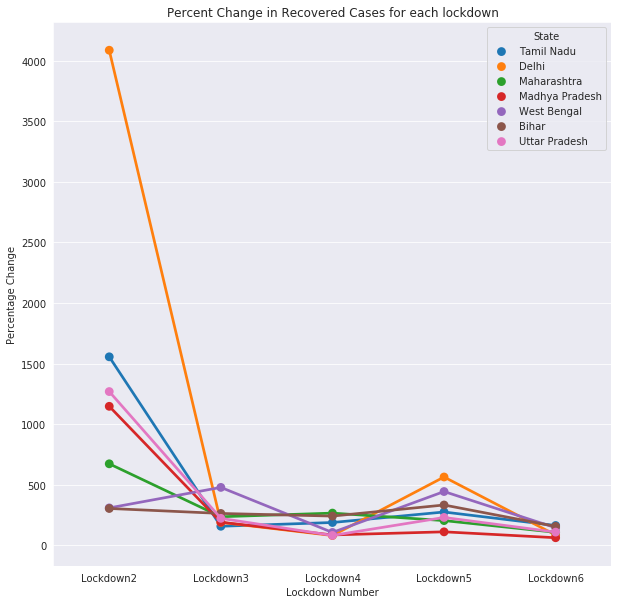

In [212]:
sns.pointplot(hue='State', 
            data=d_recovered, 
            y='%Change',
            x='Lockdown_Number')
plt.ylabel('Percentage Change')
plt.xlabel('Lockdown Number')
plt.title('Percent Change in Recovered Cases for each lockdown')
plt.show()

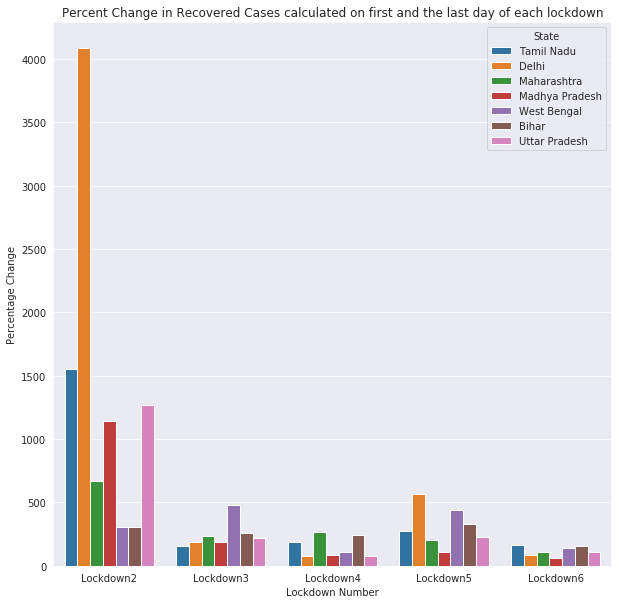

In [213]:
sns.barplot(hue='State', 
            data=d_recovered, 
            y='%Change',
            x='Lockdown_Number')
plt.ylabel('Percentage Change')
plt.xlabel('Lockdown Number')
plt.title('Percent Change in Recovered Cases calculated on first and the last day of each lockdown')
plt.show()

In [214]:
df_pct_inc = df_final[df_final.State.isin(top_7_states)][['State', 'pct_increase1', 'pct_increase2', 'pct_increase3', 'pct_increase4', 'pct_increase5', 'pct_increase6']]

In [215]:
df_pct_inc['avg_pct_inc'] = (df_pct_inc['pct_increase1'] + df_pct_inc['pct_increase2'] 
                            + df_pct_inc['pct_increase3'] + df_pct_inc['pct_increase4'] + df_pct_inc['pct_increase5'] ) / 5

In [216]:
df_pct_inc = df_pct_inc[df_pct_inc.avg_pct_inc != np.inf]

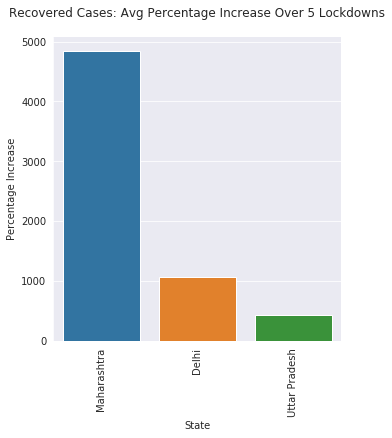

In [217]:
sns.catplot(x='State', y='avg_pct_inc', data=df_pct_inc, kind='bar')
plt.xticks(rotation=90)
plt.ylabel('Percentage Increase')
plt.title('Recovered Cases: Avg Percentage Increase Over 5 Lockdowns', pad=20)
plt.show()

### Testing Rate per Lockdown

In [218]:
df1 = lockdown1_df.loc[lockdown1_df.index.get_level_values(0).isin([start_lockdown1, end_lockdown1])][['Confirmed', 'Deaths', 'Cured', 'Active', 'TotalSamples']]
df1 = df1.unstack(0)[['TotalSamples']].dropna()
df1.columns = df1.columns.droplevel(0)
df1.columns= df1.columns.astype(str)
df1['pct_increase1'] = (df1[end_lockdown1] - df1[start_lockdown1]) / df1[start_lockdown1] * 100
df1 = df1.sort_values(by='pct_increase1', ascending=False)
df_temp1 = df1.reset_index()
df_temp1[df_temp1.State.isin(main_states)]

Date,State,2020-04-14,2020-03-25,pct_increase1
0,West Bengal,3081.0,0.0,inf
2,Bihar,7727.0,0.0,inf
5,Delhi,16282.0,0.0,inf
10,Madhya Pradesh,8105.0,0.0,inf
12,Maharashtra,41071.0,0.0,inf
18,Tamil Nadu,19255.0,0.0,inf
19,Uttar Pradesh,15914.0,0.0,inf


In [219]:
df2 = lockdown2_df.loc[lockdown2_df.index.get_level_values(0).isin([start_lockdown2, end_lockdown2])][['Confirmed', 'Deaths', 'Cured', 'Active', 'TotalSamples']]
df2 = df2.unstack(0)[['TotalSamples']].dropna()
df2.columns = df2.columns.droplevel(0)
df2.columns= df2.columns.astype(str)
df2['pct_increase2'] = (df2[end_lockdown2] - df2[start_lockdown2]) / df2[start_lockdown2] * 100
df2 = df2.sort_values(by='pct_increase2', ascending=False)
df_temp2 = df2.reset_index()
df_temp2[df_temp2.State.isin(main_states)]

Date,State,2020-05-03,2020-04-15,pct_increase2
6,Tamil Nadu,150107.0,21994.0,582.490679
7,West Bengal,22915.0,3470.0,560.374640
9,Madhya Pradesh,49186.0,9596.0,412.567737
13,Uttar Pradesh,95841.0,19506.0,391.341126
18,Delhi,60246.0,16605.0,262.818428
19,Maharashtra,159754.0,45142.0,253.892163
20,Bihar,26951.0,8263.0,226.164831


In [220]:
df3 = lockdown3_df.loc[lockdown3_df.index.get_level_values(0).isin([start_lockdown3, end_lockdown3])][['Confirmed', 'Deaths', 'Cured', 'Active', 'TotalSamples']]
df3 = df3.unstack(0)[['TotalSamples']].dropna()
df3.columns = df3.columns.droplevel(0)
df3.columns= df3.columns.astype(str)
df3['pct_increase3'] = (df3[end_lockdown3] - df3[start_lockdown3]) / df3[start_lockdown3] * 100
df3 = df3.sort_values(by='pct_increase3', ascending=False)
df_temp3 = df3.reset_index()
df_temp3[df_temp3.State.isin(main_states)]

Date,State,2020-05-17,2020-05-04,pct_increase3
1,West Bengal,85956.0,25116.0,242.236025
8,Delhi,135791.0,64108.0,111.815998
10,Tamil Nadu,326720.0,162970.0,100.478616
11,Madhya Pradesh,103898.0,52095.0,99.439486
16,Uttar Pradesh,172219.0,98300.0,75.197355
21,Maharashtra,274040.0,168374.0,62.756720
22,Bihar,45729.0,28345.0,61.330041


In [221]:
df4 = lockdown4_df.loc[lockdown4_df.index.get_level_values(0).isin([start_lockdown4, end_lockdown4])][['Confirmed', 'Deaths', 'Cured', 'Active', 'TotalSamples']]
df4 = df4.unstack(0)[['TotalSamples']].dropna()
df4.columns = df4.columns.droplevel(0)
df4.columns= df4.columns.astype(str)
df4['pct_increase4'] = (df4[end_lockdown4] - df4[start_lockdown4]) / df4[start_lockdown4] * 100
df4 = df4.sort_values(by='pct_increase4', ascending=False)
df_temp4 = df4.reset_index()
df_temp4[df_temp4.State.isin(main_states)]

Date,State,2020-05-31,2020-05-18,pct_increase4
6,West Bengal,203751.0,93570.0,117.752485
15,Uttar Pradesh,289892.0,176479.0,64.264303
16,Maharashtra,463177.0,282437.0,63.993032
17,Bihar,75737.0,46996.0,61.156269
19,Delhi,212784.0,139727.0,52.285528
22,Madhya Pradesh,167808.0,112168.0,49.604165
24,Tamil Nadu,491962.0,337841.0,45.619389


In [222]:
lockdown5_df.tail()

Cured  Deaths  Confirmed  Active  Fatality Rate  \
Date       State                                                                
2020-06-01 Chandigarh           199       4        293      90       2.010050   
           Bihar               1710      21       3815    2084       1.228070   
           Assam                185       4       1272    1083       2.162162   
           Arunachal Pradesh      1       0          4       3       0.000000   
           Andhra Pradesh      2349      62       3679    1268       2.639421   

                              TotalSamples  Negative  Positive  Population  \
Date       State                                                             
2020-06-01 Chandigarh               4816.0    4522.0     294.0     1055450   
           Bihar                   78090.0   74218.0    3872.0   104099452   
           Assam                       0.0       0.0       0.0    31205576   
           Arunachal Pradesh        8768.0    8746.0      22.0     1383727   
           Andhra Pradesh         383315.0  380197.0    3118.0    49577103   

                              Rural population  Urban population  \
Date       State                                                   
2020-06-01 Chandigarh                    28991           1026459   
           Bihar                      92341436          11758016   
           Assam                      26807034           4398542   
           Arunachal Pradesh           1066358            317369   
           Andhra Pradesh             34966693          14610410   

                                                    Area  \
Date       State                                           
2020-06-01 Chandigarh                 114 km2 (44 sq mi)   
           Bihar               94,163 km2 (36,357 sq mi)   
           Assam               78,438 km2 (30,285 sq mi)   
           Arunachal Pradesh   83,743 km2 (32,333 sq mi)   
           Andhra Pradesh     162,968 km2 (62,922 sq mi)   

                                               Density  Gender Ratio  \
Date       State                                                       
2020-06-01 Chandigarh         9,252/km2 (23,960/sq mi)           818   
           Bihar               1,102/km2 (2,850/sq mi)           918   
           Assam                 397/km2 (1,030/sq mi)           954   
           Arunachal Pradesh         17/km2 (44/sq mi)           938   
           Andhra Pradesh          303/km2 (780/sq mi)           993   

                              Public Beds  Rural Beds  Urban Beds  Total Beds  
Date       State                                                               
2020-06-01 Chandigarh                3756           0         778        4534  
           Bihar                    17796        6083        5936       29815  
           Assam                    19115       10944        6198       36257  
           Arunachal Pradesh         2320        2136         268        4724  
           Andhra Pradesh           60799        6480       16658       83937

In [223]:
df5 = lockdown5_df.loc[lockdown5_df.index.get_level_values(0).isin([start_lockdown5, end_lockdown5])][['Confirmed', 'Deaths', 'Cured', 'Active', 'TotalSamples']]
df5 = df5.unstack(0)[['TotalSamples']].dropna()
df5.columns = df5.columns.droplevel(0)
df5.columns= df5.columns.astype(str)
df5['pct_increase5'] = (df5[end_lockdown5] - df5[start_lockdown5]) / df5[start_lockdown5] * 100
df5 = df5.sort_values(by='pct_increase5', ascending=False)
df_temp5 = df5.reset_index()
df_temp5[df_temp5.State.isin(main_states)]

Date,State,2020-06-30,2020-06-01,pct_increase5
6,Bihar,220890.0,78090.0,182.865924
9,Delhi,531752.0,217537.0,144.442095
10,Uttar Pradesh,727793.0,297903.0,144.305361
13,Tamil Nadu,1170683.0,503339.0,132.583408
15,West Bengal,488038.0,213231.0,128.877602
20,Madhya Pradesh,365467.0,172019.0,112.457345
23,Maharashtra,970161.0,472344.0,105.392892


In [224]:
df6 = lockdown6_df.loc[lockdown6_df.index.get_level_values(0).isin([start_lockdown6, end_lockdown6])][['Confirmed', 'Deaths', 'Cured', 'Active', 'TotalSamples']]
df6 = df6.unstack(0)[['TotalSamples']].dropna()
df6.columns = df6.columns.droplevel(0)
df6.columns= df6.columns.astype(str)
df6['pct_increase6'] = (df6[end_lockdown6] - df6[start_lockdown6]) / df6[start_lockdown6] * 100
df6 = df6.sort_values(by='pct_increase6', ascending=False)
df_temp6 = df6.reset_index()
df_temp6[df_temp6.State.isin(main_states)]

Date,State,2020-07-23,2020-07-01,pct_increase6
2,Uttar Pradesh,1654651.0,758915.0,118.028501
9,Bihar,419208.0,228689.0,83.309210
11,Tamil Nadu,2157869.0,1202204.0,79.492748
12,Madhya Pradesh,658869.0,372811.0,76.730032
13,Maharashtra,1741992.0,995343.0,75.014241
19,Delhi,889597.0,551708.0,61.244173
24,West Bengal,758027.0,497596.0,52.337840


In [225]:
df_list = [df_temp1, df_temp2, df_temp3, df_temp4, df_temp5, df_temp6]

In [226]:
df_final = reduce(lambda left,right: pd.merge(left,right,on='State'), df_list)

In [227]:
columns = ["State", "%Change", "Lockdown_Number"]
main_states = ['Maharashtra', 'Delhi', 'Madhya Pradesh', 'West Bengal', 'Uttar Pradesh', 'Bihar', 'Tamil Nadu']
list_of_values = []

In [228]:
df_final[df_final.State.isin(main_states)]

Date,State,2020-04-14,2020-03-25,pct_increase1,2020-05-03,2020-04-15,pct_increase2,2020-05-17,2020-05-04,pct_increase3,2020-05-31,2020-05-18,pct_increase4,2020-06-30,2020-06-01,pct_increase5,2020-07-23,2020-07-01,pct_increase6
0,West Bengal,3081.0,0.0,inf,22915.0,3470.0,560.374640,85956.0,25116.0,242.236025,203751.0,93570.0,117.752485,488038.0,213231.0,128.877602,758027.0,497596.0,52.337840
2,Bihar,7727.0,0.0,inf,26951.0,8263.0,226.164831,45729.0,28345.0,61.330041,75737.0,46996.0,61.156269,220890.0,78090.0,182.865924,419208.0,228689.0,83.309210
5,Delhi,16282.0,0.0,inf,60246.0,16605.0,262.818428,135791.0,64108.0,111.815998,212784.0,139727.0,52.285528,531752.0,217537.0,144.442095,889597.0,551708.0,61.244173
10,Madhya Pradesh,8105.0,0.0,inf,49186.0,9596.0,412.567737,103898.0,52095.0,99.439486,167808.0,112168.0,49.604165,365467.0,172019.0,112.457345,658869.0,372811.0,76.730032
12,Maharashtra,41071.0,0.0,inf,159754.0,45142.0,253.892163,274040.0,168374.0,62.756720,463177.0,282437.0,63.993032,970161.0,472344.0,105.392892,1741992.0,995343.0,75.014241
18,Tamil Nadu,19255.0,0.0,inf,150107.0,21994.0,582.490679,326720.0,162970.0,100.478616,491962.0,337841.0,45.619389,1170683.0,503339.0,132.583408,2157869.0,1202204.0,79.492748
19,Uttar Pradesh,15914.0,0.0,inf,95841.0,19506.0,391.341126,172219.0,98300.0,75.197355,289892.0,176479.0,64.264303,727793.0,297903.0,144.305361,1654651.0,758915.0,118.028501


#### Preparing Data for Visualizing Per Lockdown Analysis 

In [229]:
list_of_values = []
for index, values in df_final[df_final.State.isin(main_states)].iterrows():
    l1 = []
    l2 = []
    l3 = []
    l4 = []
    l5 = []
    l6 = []

    l1.append(values['State'])
    l1.append(values['pct_increase1'])
    l1.append("Lockdown1")
    
    l2.append(values['State'])
    l2.append(values['pct_increase2'])
    l2.append("Lockdown2")
    
    l3.append(values['State'])
    l3.append(values['pct_increase3'])
    l3.append("Lockdown3")
    
    l4.append(values['State'])
    l4.append(values['pct_increase4'])
    l4.append("Lockdown4")
    
    l5.append(values['State'])
    l5.append(values['pct_increase5'])
    l5.append("Lockdown5")
    
    l6.append(values['State'])
    l6.append(values['pct_increase6'])
    l6.append("Lockdown6")
    
    list_of_values.append(l1)
    list_of_values.append(l2)
    list_of_values.append(l3)
    list_of_values.append(l4)
    list_of_values.append(l5)
    list_of_values.append(l6)

In [230]:
df_lockdown_analysis = pd.DataFrame(list_of_values, columns=columns)

In [231]:
df_lockdown_analysis.head()

,State,%Change,Lockdown_Number
0,West Bengal,inf,Lockdown1
1,West Bengal,560.374640,Lockdown2
2,West Bengal,242.236025,Lockdown3
3,West Bengal,117.752485,Lockdown4
4,West Bengal,128.877602,Lockdown5


In [232]:
df_lockdown_analysis = df_lockdown_analysis[df_lockdown_analysis['%Change'] != np.inf]

In [233]:
d_testing = df_lockdown_analysis.sort_values(by='Lockdown_Number')

In [234]:
d_testing = d_testing[~(d_testing.Lockdown_Number.isin(['Lockdown1']))]

#### Percentage Change in Recovered Cases for Main States per lockdown 

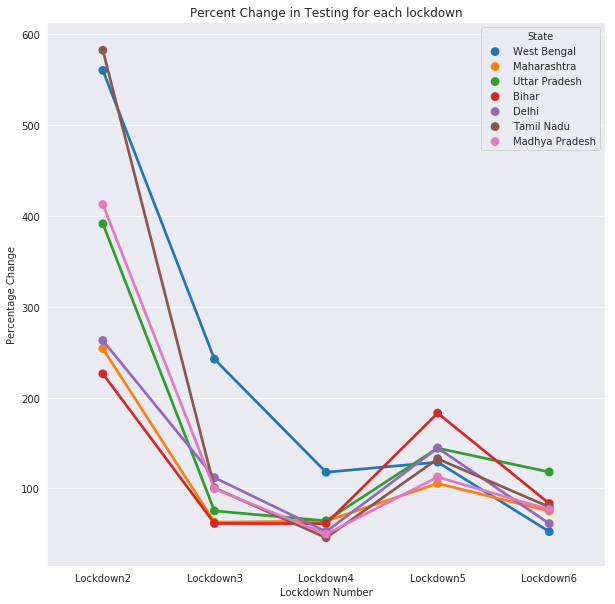

In [235]:
sns.pointplot(hue='State', 
            data=d_testing, 
            y='%Change',
            x='Lockdown_Number')
plt.ylabel('Percentage Change')
plt.xlabel('Lockdown Number')
plt.title('Percent Change in Testing for each lockdown')
plt.show()

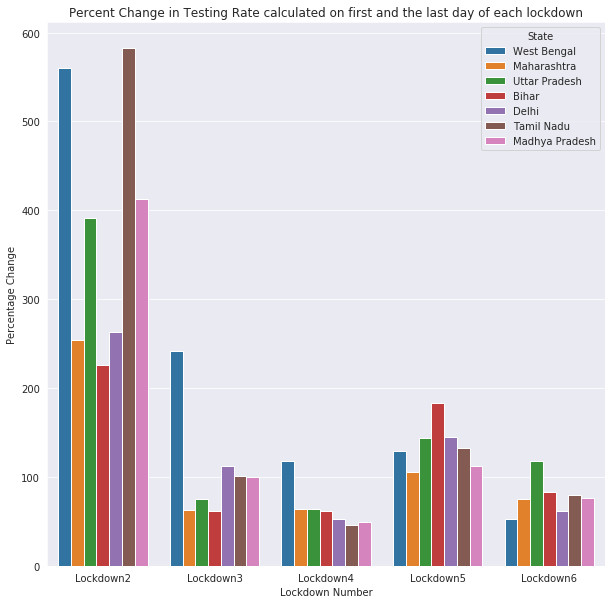

In [236]:
sns.barplot(hue='State', 
            data=d_testing, 
            y='%Change',
            x='Lockdown_Number')
plt.ylabel('Percentage Change')
plt.xlabel('Lockdown Number')
plt.title('Percent Change in Testing Rate calculated on first and the last day of each lockdown')
plt.show()

In [237]:
df_pct_inc = df_final[df_final.State.isin(['Maharashtra', 'Delhi', 'West Bengal', 'Madhya Pradesh', 'Tamil Nadu'])][['State', 'pct_increase2', 'pct_increase3', 'pct_increase4', 'pct_increase5', 'pct_increase6']]

In [238]:
df_pct_inc

Date,State,pct_increase2,pct_increase3,pct_increase4,pct_increase5,pct_increase6
0,West Bengal,560.374640,242.236025,117.752485,128.877602,52.337840
5,Delhi,262.818428,111.815998,52.285528,144.442095,61.244173
10,Madhya Pradesh,412.567737,99.439486,49.604165,112.457345,76.730032
12,Maharashtra,253.892163,62.756720,63.993032,105.392892,75.014241
18,Tamil Nadu,582.490679,100.478616,45.619389,132.583408,79.492748


In [239]:
df_pct_inc['avg_pct_inc'] = (df_pct_inc['pct_increase6'] + df_pct_inc['pct_increase2'] 
                            + df_pct_inc['pct_increase3'] + df_pct_inc['pct_increase4'] + df_pct_inc['pct_increase5'] ) / 5

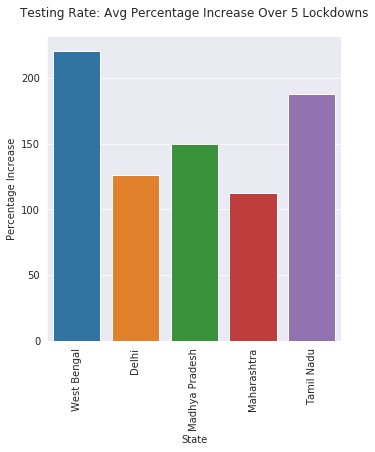

In [240]:
sns.catplot(x='State', y='avg_pct_inc', data=df_pct_inc, kind='bar')
plt.xticks(rotation=90)
plt.ylabel('Percentage Increase')
plt.title('Testing Rate: Avg Percentage Increase Over 5 Lockdowns', pad=20)
plt.show()

### Computing Doubling Rate for each State

In [241]:
df10 = maha_df.drop_duplicates(subset='Confirmed')

In [242]:
def compute_doubling_rate(confirmed_series):
    return Counter(confirmed_series.apply(math.log2).apply(math.floor).values)

In [243]:
dict_doubling_rate = dict()
for state in aggregated_df.index.get_level_values(1).unique():
    state_df = aggregated_df.loc[aggregated_df.index.get_level_values(1) == state].reset_index().set_index('Date')
    state_df = state_df.drop_duplicates(subset='Confirmed')
    state_df = state_df[state_df.Confirmed > 0]
    counter = compute_doubling_rate(state_df.Confirmed)
    if len(counter) > 0:
        dict_doubling_rate[state] = OrderedDict(counter)

### Doubling Rate for Each State

In [244]:
doubling_rate_df = pd.DataFrame(dict_doubling_rate).fillna(0)
doubling_rate_df

,West Bengal,Uttarakhand,Uttar Pradesh,Tripura,Tamil Nadu,Sikkim,Rajasthan,Punjab,Puducherry,Odisha,Nagaland,Mizoram,Meghalaya,Manipur,Maharashtra,Madhya Pradesh,Kerala,Karnataka,Jharkhand,Himachal Pradesh,Haryana,Gujarat,Goa,Delhi,Chhattisgarh,Chandigarh,Bihar,Assam,Arunachal Pradesh,Andhra Pradesh
0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
1,2.0,1.0,0.0,1.0,2.0,2.0,1.0,1.0,1.0,2.0,1.0,0.0,0.0,2.0,1.0,0.0,2.0,0.0,2.0,2.0,1.0,0.0,1.0,2.0,0.0,0.0,2.0,0.0,2.0,2.0
2,2.0,3.0,2.0,1.0,1.0,1.0,2.0,0.0,2.0,2.0,1.0,0.0,1.0,1.0,1.0,3.0,0.0,2.0,1.0,1.0,0.0,2.0,3.0,4.0,2.0,3.0,2.0,1.0,1.0,2.0
3,3.0,1.0,5.0,0.0,2.0,2.0,1.0,1.0,4.0,0.0,0.0,2.0,6.0,1.0,2.0,1.0,3.0,3.0,1.0,1.0,2.0,0.0,2.0,3.0,3.0,2.0,3.0,0.0,0.0,5.0
4,3.0,4.0,6.0,2.0,3.0,0.0,3.0,2.0,3.0,2.0,2.0,3.0,3.0,3.0,0.0,2.0,7.0,1.0,6.0,2.0,5.0,2.0,2.0,5.0,3.0,9.0,4.0,7.0,1.0,2.0
5,3.0,17.0,4.0,1.0,2.0,1.0,6.0,7.0,3.0,7.0,4.0,2.0,9.0,6.0,6.0,1.0,2.0,4.0,8.0,13.0,6.0,5.0,6.0,3.0,10.0,2.0,4.0,10.0,7.0,1.0
6,7.0,11.0,5.0,2.0,2.0,15.0,3.0,3.0,5.0,10.0,6.0,8.0,2.0,5.0,4.0,3.0,4.0,5.0,9.0,9.0,2.0,7.0,7.0,2.0,6.0,5.0,10.0,7.0,6.0,2.0
7,6.0,3.0,3.0,16.0,1.0,8.0,2.0,9.0,6.0,9.0,10.0,16.0,1.0,3.0,6.0,2.0,6.0,9.0,11.0,6.0,9.0,4.0,2.0,2.0,4.0,13.0,4.0,3.0,12.0,4.0
8,6.0,5.0,7.0,4.0,3.0,7.0,5.0,6.0,7.0,5.0,10.0,6.0,9.0,9.0,3.0,2.0,34.0,14.0,9.0,18.0,9.0,2.0,7.0,2.0,7.0,40.0,7.0,3.0,11.0,8.0
9,10.0,4.0,5.0,9.0,7.0,0.0,6.0,1.0,5.0,7.0,17.0,0.0,2.0,8.0,3.0,4.0,18.0,18.0,8.0,19.0,16.0,5.0,12.0,5.0,6.0,16.0,13.0,4.0,8.0,8.0


#### Inferences:

1. For confirmed cases, Maharashtra has a doubling rate of 23 days.
2. Delhi has a doubling rate of 25 days.


### India's doubling rate 

In [245]:
list_doubling_rate = []
dict_latest_doubling_rate = dict()
for key, value in dict_doubling_rate.items():
    current_doubling_rate = value[list(value.keys())[0]]
    previous_doubling_rate = value[list(value.keys())[1]]
    doubling_rate =  current_doubling_rate if current_doubling_rate > previous_doubling_rate else previous_doubling_rate
    list_doubling_rate.append(doubling_rate)
    dict_latest_doubling_rate[key] = doubling_rate

In [246]:
print(f"India's Confirmed Cases doubling rate is: {sum(list_doubling_rate) / len(list_doubling_rate)}")

India's Confirmed Cases doubling rate is: 20.0


### Doubling Rate removing small states

In [247]:
list_doubling_rate = []
list_of_latest_doubling_rate = []
for key, value in dict_doubling_rate.items():
    current_doubling_rate = value[list(value.keys())[0]]
    previous_doubling_rate = value[list(value.keys())[1]]
    doubling_rate =  current_doubling_rate if current_doubling_rate > previous_doubling_rate else previous_doubling_rate
    if(doubling_rate > 11):
        list_doubling_rate.append(doubling_rate)
        list_of_latest_doubling_rate.append(tuple([key, doubling_rate]))

In [248]:
print(f"India's Confirmed Cases excluding small states doubling rate is: {sum(list_doubling_rate) / len(list_doubling_rate)}")

India's Confirmed Cases excluding small states doubling rate is: 22.583333333333332


In [249]:
list_of_latest_doubling_rate

[('West Bengal', 17),
 ('Uttarakhand', 29),
 ('Uttar Pradesh', 20),
 ('Tripura', 28),
 ('Tamil Nadu', 17),
 ('Rajasthan', 27),
 ('Punjab', 22),
 ('Odisha', 14),
 ('Nagaland', 17),
 ('Mizoram', 16),
 ('Manipur', 27),
 ('Maharashtra', 23),
 ('Madhya Pradesh', 39),
 ('Kerala', 14),
 ('Jharkhand', 24),
 ('Himachal Pradesh', 21),
 ('Haryana', 20),
 ('Gujarat', 31),
 ('Goa', 13),
 ('Delhi', 31),
 ('Chhattisgarh', 21),
 ('Chandigarh', 40),
 ('Bihar', 18),
 ('Assam', 13)]

In [250]:
df_doubling_rate = pd.DataFrame(list_of_latest_doubling_rate, columns=['State', 'Doubling_Rate'])
df_temp = df_doubling_rate[df_doubling_rate.State.isin(main_states)]

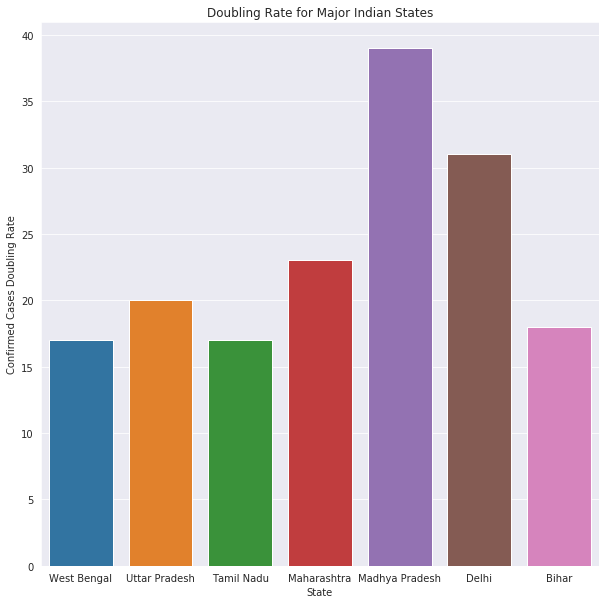

In [251]:
sns.barplot(data=df_temp, 
            y='Doubling_Rate',
            x='State')
plt.ylabel('Confirmed Cases Doubling Rate')
plt.xlabel('State')
plt.title('Doubling Rate for Major Indian States')
plt.show()

### Forecasting Confirmed Cases in Maharashtra

In [252]:
def get_list_of_arma_model_parameters(df, no_of_lags):
    """ Helper Function to return list of tuple of ARMA params like (ar, ma, aic, bic)"""
    list_tup = []
    for i in range(10):
        for j in range(10):
            try:
                ARIMA_model = ARIMA(df, order=(i, no_of_lags, j)).fit(transparams=False)
                t = tuple([i, j, ARIMA_model.aic, ARIMA_model.bic])
                list_tup.append(t)
            except Exception as e:
                print(e)
    return list_tup

In [253]:
def get_best_ar_ma_value(list_of_tup):
    """ Helper Function to return best fit params from list of tuple of ARMA params like (ar, ma, aic, bic)"""
    least_bic = list_tup[0][3]
    best_params = list_tup[0]
    list_of_best_params = []
    for tup in list_of_tup:
        if tup[3] < least_bic:
            best_params = tup
            least_bic = tup[3]
    return best_params

In [254]:
d = df10[df10['Confirmed'].diff() > 0].fillna(df10)[['Confirmed']]
d = d.diff()
d = d.reset_index()

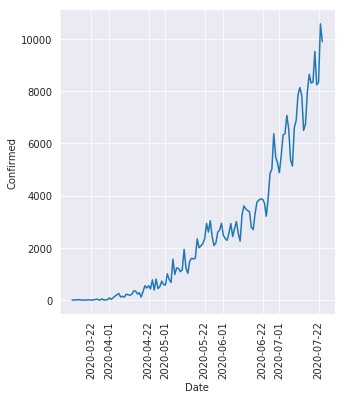

In [255]:
sns.relplot(y='Confirmed', x='Date', kind='line', data=d)
plt.xticks(rotation=90)
plt.show()

In [256]:
d = d.set_index('Date')

In [257]:
df_new = d[d['Confirmed'].diff() > 0].fillna(d)[['Confirmed']]
d2 = df_new.diff()
d2 = d2.diff()
d2 = d2.reset_index()
d2 = d2.dropna()

In [258]:
d = d.dropna()

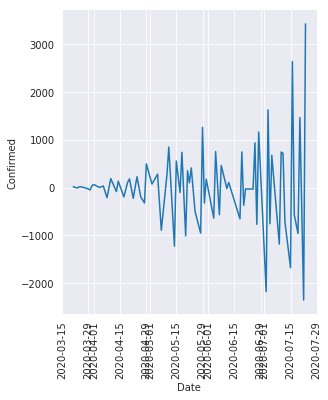

In [259]:
sns.relplot(y='Confirmed', x='Date', kind='line', data=d2)
plt.xticks(rotation=90)
plt.show()

In [260]:
d2 = d2.set_index('Date')

In [261]:
d2 = d2.dropna()

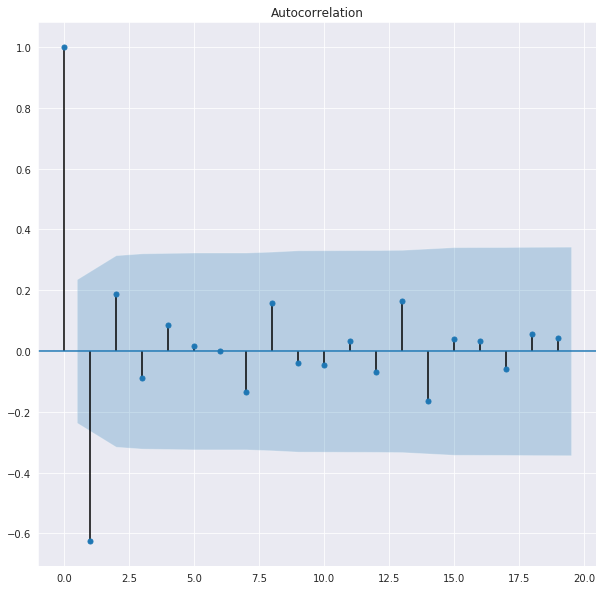

In [262]:
plot_acf(d2)
plt.show()

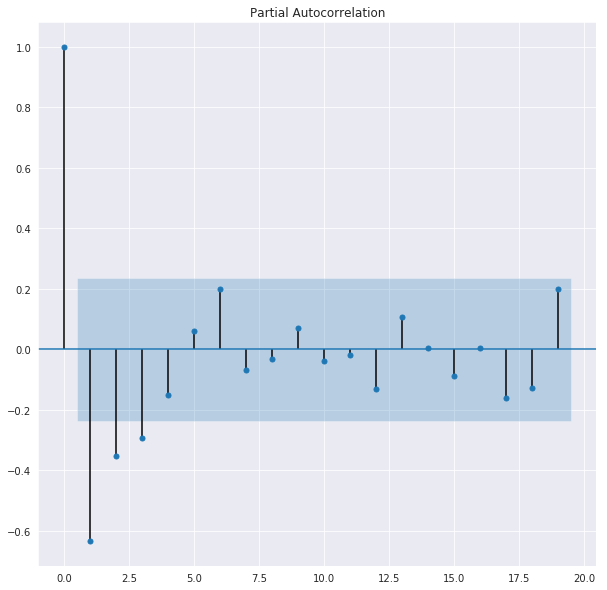

In [263]:
plot_pacf(d2)
plt.show()

In [264]:
list_tup = get_list_of_arma_model_parameters(d, 2)

/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but 

The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but 

The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but 

The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are

/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but 

The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are

/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored

The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but 

The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but 

The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored

The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but 

The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but 

The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
On entry to DLASCL parameter number 4 had an illegal value
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but 

On entry to DLASCL parameter number 4 had an illegal value


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but 

On entry to DLASCL parameter number 4 had an illegal value
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but 

On entry to DLASCL parameter number 4 had an illegal value
On entry to DLASCL parameter number 4 had an illegal value


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but 

On entry to DLASCL parameter number 4 had an illegal value


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


On entry to DLASCL parameter number 4 had an illegal value


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


On entry to DLASCL parameter number 4 had an illegal value


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/

The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are no

/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Convergenc

On entry to DLASCL parameter number 4 had an illegal value


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


On entry to DLASCL parameter number 4 had an illegal value


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


On entry to DLASCL parameter number 4 had an illegal value


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


On entry to DLASCL parameter number 4 had an illegal value
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but 

The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


On entry to DLASCL parameter number 4 had an illegal value


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


On entry to DLASCL parameter number 4 had an illegal value
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your o

/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but 

In [265]:
ar, ma, aic, bic = get_best_ar_ma_value(list_tup)

In [266]:
ARMA_model = ARIMA(d, order=(ar, 2, ma)).fit()

/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [267]:
ARMA_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:           D2.Confirmed   No. Observations:                  128
Model:                 ARIMA(6, 2, 1)   Log Likelihood                -939.847
Method:                       css-mle   S.D. of innovations            364.039
Date:                Sun, 26 Jul 2020   AIC                           1897.694
Time:                        12:17:24   BIC                           1923.362
Sample:                             2   HQIC                          1908.123
                                                                              
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  1.9218      1.891      1.016      0.309      -1.784       5.628
ar.L1.D2.Confirmed    -0.7380      0.116     -6.387      0.000      -0.964      -0.512
ar.L2.D2.Confirmed    -0.8603      0.104     -8.300      0.000      -1.063      -0.657
ar.L3.D2.Confirmed    -0.7148      0.118     -6.042      0.000      -0.947      -0.483
ar.L4.D2.Confirmed    -0.7461      0.108     -6.908      0.000      -0.958      -0.534
ar.L5.D2.Confirmed    -0.7806      0.099     -7.894      0.000      -0.974      -0.587
ar.L6.D2.Confirmed    -0.4991      0.111     -4.498      0.000      -0.717      -0.282
ma.L1.D2.Confirmed    -0.6992      0.137     -5.093      0.000      -0.968      -0.430
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.6406           -0.8226j            1.0427           -0.1447
AR.2            0.6406           +0.8226j            1.0427            0.1447
AR.3           -0.2862           -1.0339j            1.0728           -0.2930
AR.4           -0.2862           +1.0339j            1.0728            0.2930
AR.5           -1.1364           -0.5568j            1.2655           -0.4275
AR.6           -1.1364           +0.5568j            1.2655            0.4275
MA.1            1.4302           +0.0000j            1.4302            0.0000
-----------------------------------------------------------------------------
"""